# Final Assignment
## CM3015 Machine Learning and Neural Networks

### Credit Card Fraud Detection with a Feedforward MLP

- Student: cy150
- Workflow: Chollet's ML workflow (problem → data → evaluation → prep → baseline → model → tuning → final eval)

---

## Step 1 — Define the problem

Chollet’s workflow keeps the project aligned with real‑world goals. It moves in clear stages from problem definition to data understanding, evaluation design, preparation, baseline, model building, tuning, and final reporting.

### Overview: Credit Card Fraud

Credit card fraud is the unauthorized use of a credit (or debit) card to make purchases, withdraw funds, or create transactions that the legitimate cardholder did not approve.

### Problem Statement


- Credit card fraud causes direct and significant financial losses: issuers, merchants, and consumers may absorb losses from unauthorized purchases and chargebacks. Fraud also creates investigative overhead (reviews, disputes) and temporary loss of funds and reputation. As a result, stricter verification and KYC are implemented by merchants and banks.

-  These organizations can also lose customers if there are excessive false declines or chargebacks. Additionally, failure to protect customers according to regulatory standards can incur penalties to banks themselves proving that credit card fraud detection is a critical technology for a functioning, safe banking and finance environment
---

### Success Metrics

#### Objective

The primary objective is to detect fraudulent transactions while minimizing false positives. Because fraud is rare, the evaluation focuses on minority-class performance and selecting an operating point that reflects the cost of errors.

## Step 2 — Identify and understand the data

### Dataset Overview
This dataset consists of credit card transactions by European cardholders. It covers two days of transactions with 492 frauds out of 284,807 transactions.
The dataset is highly imbalanced, with frauds accounting for about 0.172% of all transactions.


> **Note:** The visual exploration (EDA) of this dataset is carried out in Step 4 after the data has been loaded. This step focuses on the dataset's metadata, provenance, and suitability for the task.

### Nature of the Dataset

It contains only numerical input variables resulting from a PCA transformation. Due to confidentiality, the original features and more background information are not available.

### Dataset Features
Features V1, V2, … V28 are principal components from PCA. The only features not transformed with PCA are `Time` and `Amount`.

- `Time` contains the seconds elapsed between each transaction and the first transaction in the dataset.

*Example*

| Time |      V1 |      V2 |     V3 |     V4 |      V5 |
| ---: | ------: | ------: | -----: | -----: | ------: |
|    0 | -1.3598 | -0.0728 | 2.5363 | 1.3782 | -0.3383 |
|    1 |  1.1919 |  0.2662 | 0.1665 | 0.4482 |  0.0600 |
|    1 | -1.3584 | -1.3402 | 1.7732 | 0.3798 | -0.5032 |


### Dataset Licensing

The dataset is licensed under the Database Contents License (DbCL).

According to the license (Open Data Commons), the Licensor grants a worldwide, royalty-free, non-exclusive, perpetual, irrevocable copyright license to do any act that is restricted by copyright over anything within the Contents, whether in the original medium or any other. These rights explicitly include commercial use and do not exclude any field of endeavor.

### Permission

The DbCL license explicitly allows use of this dataset for this final assignment.

### Dataset Author

- Machine Learning Group - ULB 

### Dataset Source

After browsing Kaggle, I selected a dataset that is complex and challenging while providing rich features for the model to learn from.

Link to dataset: `https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data`

### Justification for this dataset

This dataset supports a full end-to-end deep learning workflow: clear labels, numeric features, and a real-world class imbalance that demands careful evaluation.

#### Rationale behind why this dataset was chosen

- It matches the **problem framing**: a real-world binary classification task where the positive class (fraud) is rare and costly to miss.
- It matches the **data modality**: fixed-length, fully numeric, tabular features that are well-suited to a feedforward MLP as a strong first baseline.
- It forces a realistic **evaluation setup**: extreme imbalance means accuracy is not meaningful, so the workflow naturally prioritizes PR AUC, precision/recall, and explicit threshold selection.
- It encourages good **experimental discipline**: preprocessing must be fit on the training split only (to avoid leakage) and the final test set can be kept untouched for a single, final report.

#### Limitations of this dataset and mitigation strategy

- **Limited interpretability**: V1–V28 are anonymized PCA components, so feature-level explanations are not meaningful.
  - *Mitigation*: focus on predictive performance, stability across runs, and careful threshold selection rather than per-feature interpretation.
- **Potential time effects**: `Time` reflects ordering within the 2-day window.
  - *Mitigation*: use a time-aware split (train on earlier, validate/test on later) to better reflect deployment.

---

## Step 3 — Choose an evaluation protocol

### Holdout Protocol

1. The data will be split into:

    - Training set
    - Validation set
    - Test set

   **Why**: we need separate data for learning parameters (train), choosing settings (validation), and an unbiased final report (test).

   **How**: use a time-aware split when possible (earlier transactions → train, later → validation/test) so evaluation better matches deployment.

2. Preprocessing decisions are fitted using the training set exclusively.

   **Why**: using any information from validation/test (even feature scaling statistics) leaks signal and inflates performance.

   **How**: fit transforms on `X_train` only (e.g., standardization mean/std, any imputation rules), then apply the fitted transforms unchanged to `X_val` and `X_test`.

3. The validation set is only used for model and threshold selection.

   **Why**: the validation set simulates unseen data during development; using it only for selection reduces the risk of overfitting the final report.

   **How**: compare candidate models using PR AUC/recall/precision on validation; choose hyperparameters and pick an operating threshold (e.g., maximize recall subject to minimum precision) using validation predictions.

4. Final performance is evaluated on the untouched test set.

   **Why**: the test set should be a single, unbiased estimate of how the chosen pipeline will perform in the real world.

   **How**: once preprocessing + model + threshold are finalized, run inference once on `X_test` and report the locked metrics (PR AUC and confusion matrix at the chosen threshold).


### Evaluation metrics

This section describes how performance will be measured based on the pre-defined success criteria.

### Primary Metrics

| Metric               | What it measures                                                       | Why it matters for fraud under heavy class imbalance                                                    |
| -------------------- | ---------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------- |
| Precision–Recall AUC | Area under the precision–recall curve across decision thresholds       | Strong overall summary metric when fraud is rare, more informative than accuracy                        |
| Recall               | True positive rate, how many actual fraud cases are correctly detected | Directly captures missed fraud risk since low recall means more fraud slips through                     |
| F1 Score             | Harmonic mean of precision and recall                                  | Useful single number when you want a balanced tradeoff between catching fraud and limiting false alarms |


### Secondary Metrics

| Secondary metric                              | Description                                                                                                       | Purpose                                                                                        |
| --------------------------------------------- | ----------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------- |
| Confusion matrix at a predetermined threshold | Uses TP, FP, TN, FN to make tradeoffs explicit                                                                    | Shows performance at the chosen operating point and clarifies the cost of each type of mistake |
| Error rates                                   | False negative rate and false positive rate to quantify misses and false alarms                                   | Measures miss risk versus false alarm burden in a comparable way                               |
| Calibration check                             | Compare predicted probabilities with observed outcomes using a simple binning table to verify probability quality | Checks whether predicted risk scores align with real observed fraud rates                      |


#### Justification for evaluation metrics

Fraud is a rare event, so a single metric can be misleading. A model may look strong on one metric while failing in practice. The primary metric provides a consistent rule for model comparison, while secondary metrics provide the context needed to interpret false-positive and false-negative tradeoffs.

### Implications of the evaluation metrics

1. Precision reflects workload and customer friction.
2. Recall reflects loss prevention, often translating into direct financial losses.
3. PR AUC reflects ranking quality under rare fraud across thresholds.
4. The confusion matrix is reported at an operating threshold aligned with transaction behavior.


## Step 4 — Prepare the data

### Data preparation plan

To prepare the data and avoid leakage:

1. Use a time-aware split: earlier transactions for training, later transactions for validation/test.
2. Fit all preprocessing steps (scaling, imputation if needed) on the training set only.
3. Apply the same fitted transforms to validation and test sets.
4. Preserve the class imbalance during splitting to reflect real deployment.
5. Track feature distributions and label rate over time to identify drift.
6. Use a small threshold sweep on the validation set for later operating-point selection.
7. Calibrate probabilities with simple binning to sanity-check outputs.
8. Re-train periodically as base rates drift in production.

### Data checks and class imbalance

- Check for missing values, big outliers, and changes between the train/val/test splits.
- Scale features using numbers from the training set only.
- Handle imbalance with class weights or resampling.
- Keep notes of every preprocessing step so results are repeatable.

---

### Step 4 implementation (code)

The code below loads the dataset from `data/creditcard.csv`.
If the file is missing, it will try to download it using `kagglehub` and then save it to `data/creditcard.csv`.

- Expected columns include `Time`, `Amount`, `V1`…`V28`, and `Class` (target label).


In [1]:
import sys

# Install into THIS kernel environment
%pip -q install -U "kagglehub[pandas-datasets]"

import kagglehub
import pandas as pd

print("Kernel Python:", sys.version)
print("Kernel executable:", sys.executable)

# Download the raw file first, then read with pandas (avoids kagglehub's UTF-8 encoding issue)
dataset_path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Dataset downloaded to:", dataset_path)

import os
csv_path = os.path.join(dataset_path, "creditcard.csv")
df = pd.read_csv(csv_path)

print(f"Shape: {df.shape}")
print(df.head())



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Kernel Python: 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
Kernel executable: c:\Users\Yangu\AppData\Local\Programs\Python\Python39\python.exe
Dataset downloaded to: C:\Users\Yangu\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3
Shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  

In [2]:
from pathlib import Path
import os

import numpy as np
import pandas as pd

DATA_PATH = Path("data/creditcard.csv")

# If the CSV isn't present locally, try fetching it via kagglehub.
if not DATA_PATH.exists():
    try:
        import kagglehub

        # Download the raw files (avoids kagglehub's internal UTF-8 read issue)
        dataset_dir = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
        src_csv = os.path.join(dataset_dir, "creditcard.csv")
        df = pd.read_csv(src_csv)

        # Cache locally so future runs don't re-download
        DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(DATA_PATH, index=False)
        print("Downloaded via kagglehub and saved to:", DATA_PATH)
    except Exception as e:
        raise FileNotFoundError(
            f"Could not find {DATA_PATH} and kagglehub download failed.\n"
            "Either place the file at data/creditcard.csv, or configure Kaggle access for kagglehub, then rerun.\n"
            f"Original error: {type(e).__name__}: {e}"
        ) from e
else:
    df = pd.read_csv(DATA_PATH)
    print("Loaded:", DATA_PATH)

print("Shape:", df.shape)
print(df.head(3))

if "Class" not in df.columns:
    raise ValueError("Expected a 'Class' column (0=legit, 1=fraud).")

fraud_rate = df["Class"].mean()
print(f"Fraud rate: {fraud_rate:.6f} ({df['Class'].sum()} / {len(df)})")


Loaded: data\creditcard.csv
Shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]
Fraud rate: 0.001727 (492 / 284807)


### Exploratory Data Analysis (EDA) — Visualizing the Dataset

Before splitting and modelling, we explore the dataset visually. These charts serve several purposes:

| # | EDA focus | Why it matters |
|---|-----------|----------------|
| 1 | **Class distribution** | Quantify and visualize the extreme imbalance between fraud and non-fraud. |
| 2 | **Transaction amount** | Compare the spending patterns of fraudulent vs legitimate transactions. |
| 3 | **Transaction time** | Examine when transactions (and fraud) occur over the 2-day window. |
| 4 | **Feature correlations** | Identify which features are most associated with the target and with each other. |
| 5 | **Feature distributions by class** | Highlight which PCA components separate fraud from non-fraud most clearly. |
| 6 | **Dimensionality reduction** | Use t-SNE to project all 30 features into 2D and visualize class separation. |

All visualizations use the full dataset before any splitting, so no leakage concerns arise at this stage.

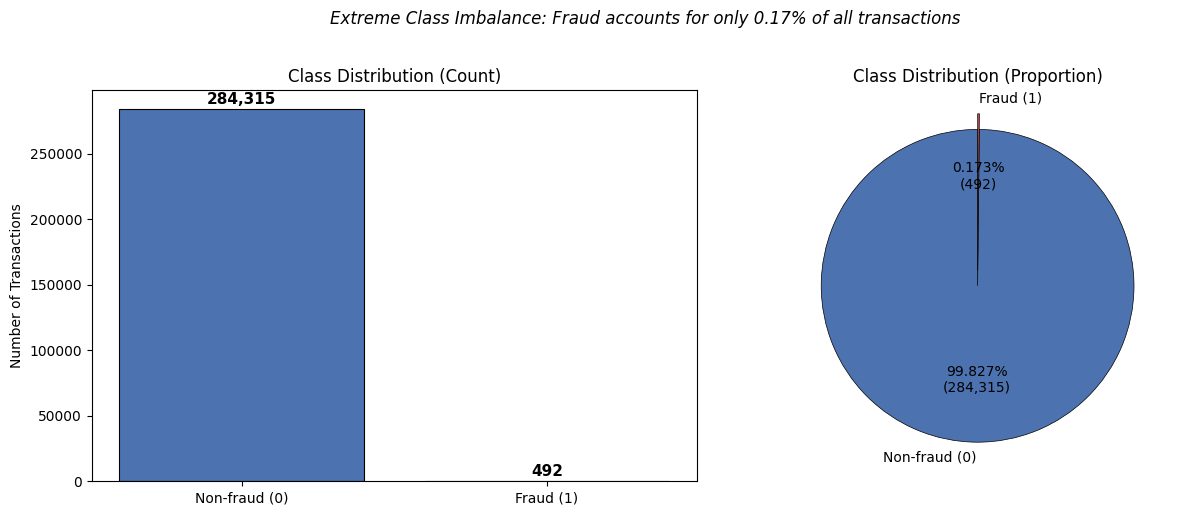

Non-fraud:  284,315  (99.8273%)
Fraud:          492  (0.1727%)
Imbalance ratio: 1 fraud per 577 legitimate transactions


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------------
# 1. Class Distribution — Bar chart + Pie chart
# ---------------------------------------------------------------------------
class_counts = df["Class"].value_counts().sort_index()
labels = ["Non-fraud (0)", "Fraud (1)"]
colors = ["#4c72b0", "#c44e52"]

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Bar chart with log-scale option for visibility
bars = axes[0].bar(labels, class_counts.values, color=colors, edgecolor="black", linewidth=0.8)
axes[0].set_ylabel("Number of Transactions")
axes[0].set_title("Class Distribution (Count)")
for bar, count in zip(bars, class_counts.values):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1500,
                 f"{count:,}", ha="center", va="bottom", fontsize=11, fontweight="bold")

# Pie chart with percentage
axes[1].pie(
    class_counts.values,
    labels=labels,
    autopct=lambda pct: f"{pct:.3f}%\n({int(round(pct / 100 * class_counts.sum())):,})",
    colors=colors,
    startangle=90,
    explode=(0, 0.1),
    textprops={"fontsize": 10},
    wedgeprops={"edgecolor": "black", "linewidth": 0.5},
)
axes[1].set_title("Class Distribution (Proportion)")

plt.suptitle("Extreme Class Imbalance: Fraud accounts for only 0.17% of all transactions",
             fontsize=12, y=1.02, fontstyle="italic")
plt.tight_layout()
plt.show()

print(f"Non-fraud: {class_counts[0]:>8,}  ({class_counts[0]/len(df)*100:.4f}%)")
print(f"Fraud:     {class_counts[1]:>8,}  ({class_counts[1]/len(df)*100:.4f}%)")
print(f"Imbalance ratio: 1 fraud per {class_counts[0]//class_counts[1]:,} legitimate transactions")

C:\Users\Yangu\AppData\Local\Temp\ipykernel_41924\2906343844.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[2].boxplot(box_data, labels=["Non-fraud", "Fraud"], patch_artist=True,


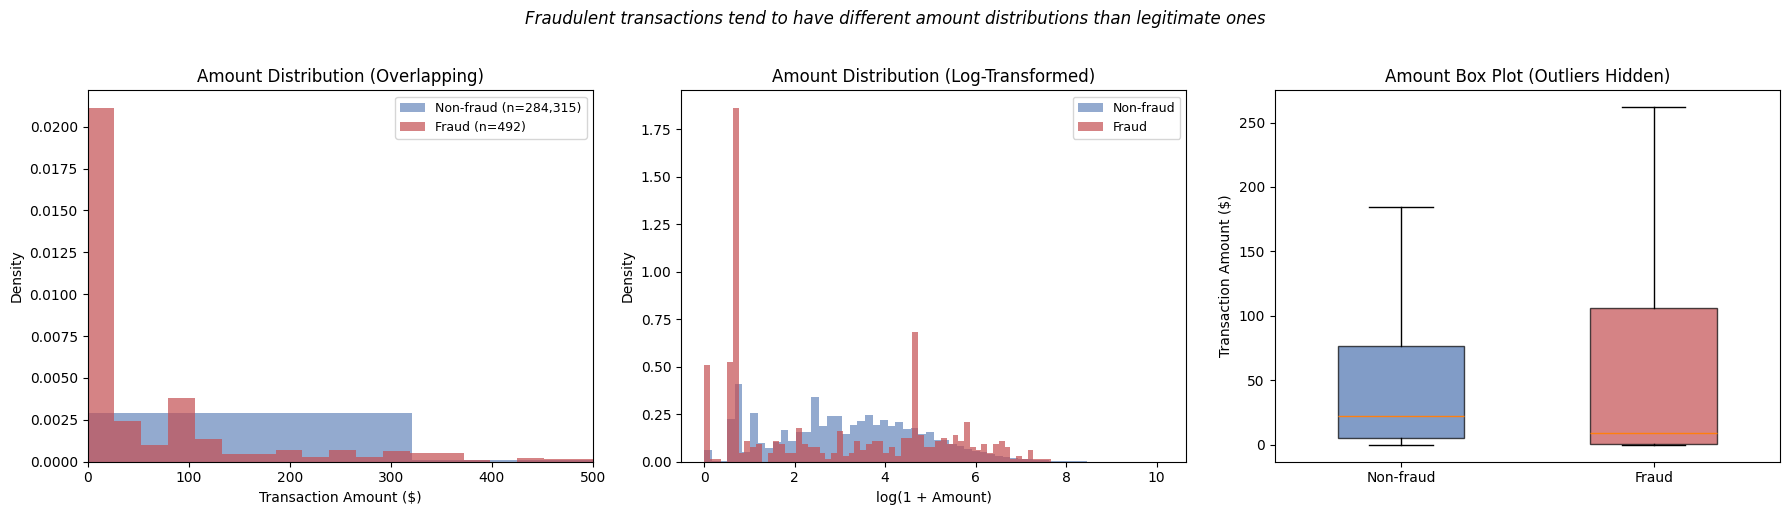

Amount summary statistics:
  Non-fraud — mean: $88.29, median: $22.00, std: $250.11, max: $25691.16
  Fraud     — mean: $122.21, median: $9.25, std: $256.68, max: $2125.87


In [4]:
# ---------------------------------------------------------------------------
# 2. Transaction Amount Distribution — Fraud vs Non-fraud
# ---------------------------------------------------------------------------
fraud_amounts = df.loc[df["Class"] == 1, "Amount"]
legit_amounts = df.loc[df["Class"] == 0, "Amount"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) Overlapping histograms (log scale on y-axis for visibility)
axes[0].hist(legit_amounts, bins=80, alpha=0.6, color="#4c72b0",
             label=f"Non-fraud (n={len(legit_amounts):,})", density=True)
axes[0].hist(fraud_amounts, bins=80, alpha=0.7, color="#c44e52",
             label=f"Fraud (n={len(fraud_amounts):,})", density=True)
axes[0].set_xlabel("Transaction Amount ($)")
axes[0].set_ylabel("Density")
axes[0].set_title("Amount Distribution (Overlapping)")
axes[0].legend(fontsize=9)
axes[0].set_xlim(0, 500)

# (b) Log-transformed amount histogram
axes[1].hist(np.log1p(legit_amounts), bins=60, alpha=0.6, color="#4c72b0",
             label="Non-fraud", density=True)
axes[1].hist(np.log1p(fraud_amounts), bins=60, alpha=0.7, color="#c44e52",
             label="Fraud", density=True)
axes[1].set_xlabel("log(1 + Amount)")
axes[1].set_ylabel("Density")
axes[1].set_title("Amount Distribution (Log-Transformed)")
axes[1].legend(fontsize=9)

# (c) Box plot comparison
box_data = [legit_amounts.values, fraud_amounts.values]
bp = axes[2].boxplot(box_data, labels=["Non-fraud", "Fraud"], patch_artist=True,
                     showfliers=False, widths=0.5)
bp["boxes"][0].set_facecolor("#4c72b0")
bp["boxes"][1].set_facecolor("#c44e52")
for box in bp["boxes"]:
    box.set_alpha(0.7)
axes[2].set_ylabel("Transaction Amount ($)")
axes[2].set_title("Amount Box Plot (Outliers Hidden)")

plt.suptitle("Fraudulent transactions tend to have different amount distributions than legitimate ones",
             fontsize=12, y=1.02, fontstyle="italic")
plt.tight_layout()
plt.show()

# Summary statistics
print("Amount summary statistics:")
print(f"  Non-fraud — mean: ${legit_amounts.mean():.2f}, median: ${legit_amounts.median():.2f}, "
      f"std: ${legit_amounts.std():.2f}, max: ${legit_amounts.max():.2f}")
print(f"  Fraud     — mean: ${fraud_amounts.mean():.2f}, median: ${fraud_amounts.median():.2f}, "
      f"std: ${fraud_amounts.std():.2f}, max: ${fraud_amounts.max():.2f}")

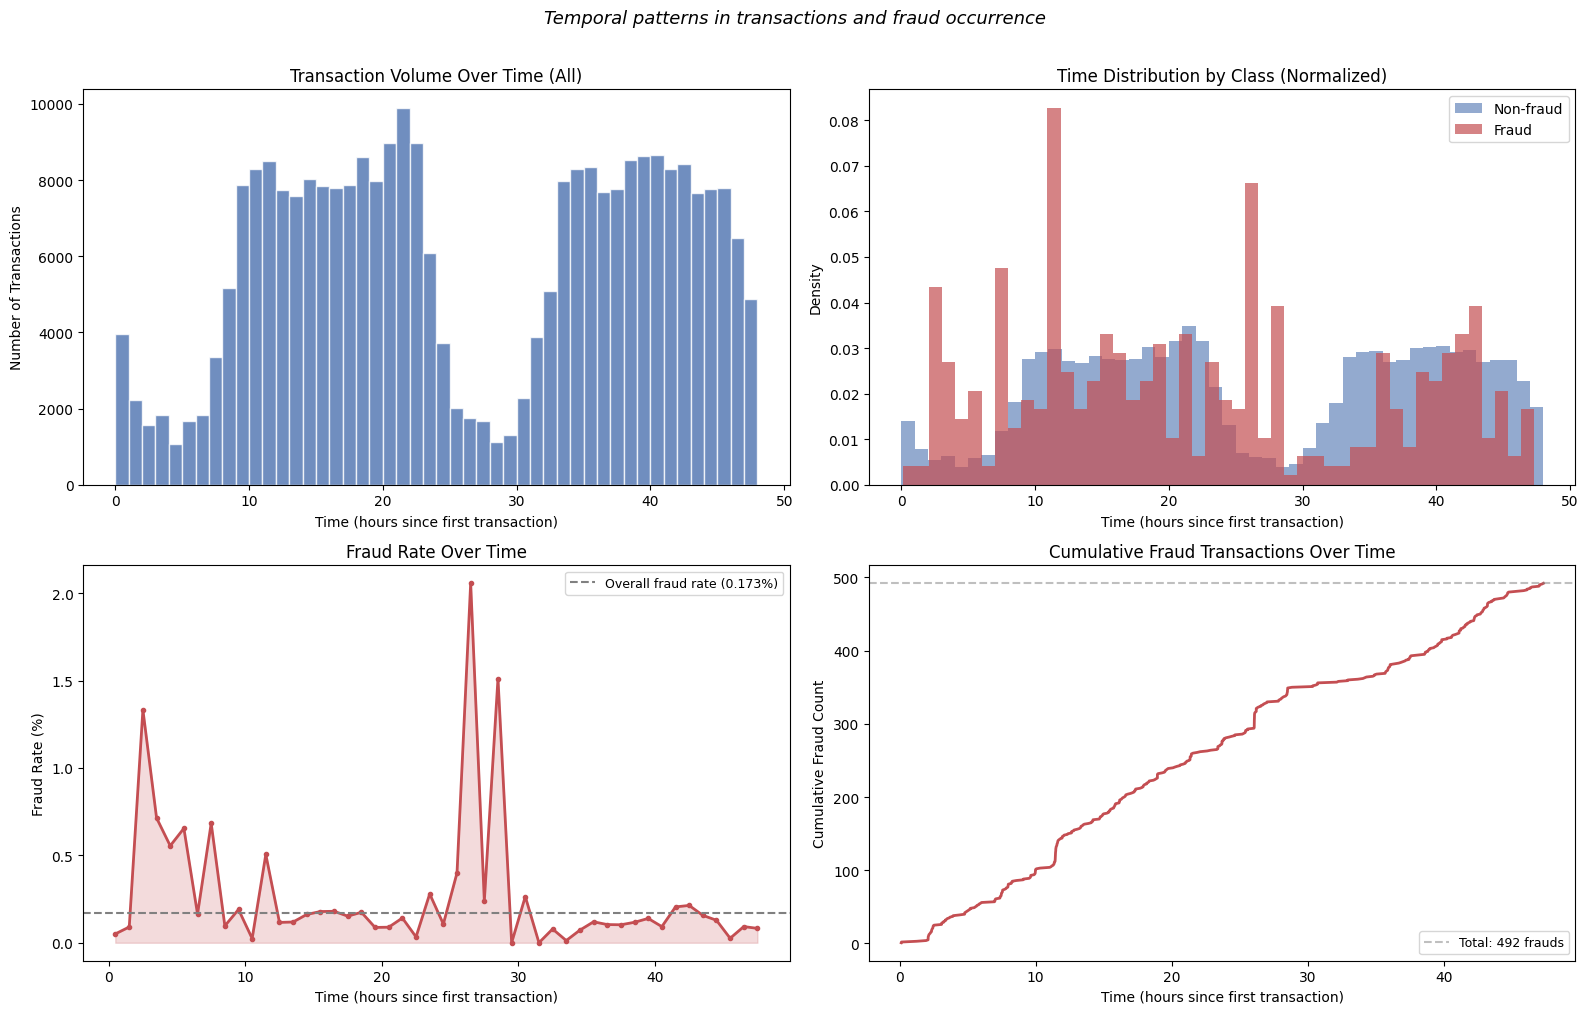

In [5]:
# ---------------------------------------------------------------------------
# 3. Transaction Time Distribution — Fraud vs Non-fraud + Fraud rate over time
# ---------------------------------------------------------------------------
time_hours = df["Time"] / 3600  # convert seconds to hours

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# (a) Overall transaction volume over time
axes[0, 0].hist(time_hours, bins=48, color="#4c72b0", edgecolor="white", alpha=0.8)
axes[0, 0].set_xlabel("Time (hours since first transaction)")
axes[0, 0].set_ylabel("Number of Transactions")
axes[0, 0].set_title("Transaction Volume Over Time (All)")

# (b) Fraud vs Non-fraud time distribution
axes[0, 1].hist(time_hours[df["Class"] == 0], bins=48, alpha=0.6, color="#4c72b0",
                label="Non-fraud", density=True)
axes[0, 1].hist(time_hours[df["Class"] == 1], bins=48, alpha=0.7, color="#c44e52",
                label="Fraud", density=True)
axes[0, 1].set_xlabel("Time (hours since first transaction)")
axes[0, 1].set_ylabel("Density")
axes[0, 1].set_title("Time Distribution by Class (Normalized)")
axes[0, 1].legend()

# (c) Fraud rate over time (binned)
n_bins_time = 48
time_bins = pd.cut(time_hours, bins=n_bins_time)
fraud_rate_by_time = df.groupby(time_bins, observed=False)["Class"].mean()
bin_centers = [interval.mid for interval in fraud_rate_by_time.index]

axes[1, 0].plot(bin_centers, fraud_rate_by_time.values * 100, color="#c44e52",
                linewidth=2, marker="o", markersize=3)
axes[1, 0].fill_between(bin_centers, fraud_rate_by_time.values * 100,
                         alpha=0.2, color="#c44e52")
axes[1, 0].set_xlabel("Time (hours since first transaction)")
axes[1, 0].set_ylabel("Fraud Rate (%)")
axes[1, 0].set_title("Fraud Rate Over Time")
axes[1, 0].axhline(y=df["Class"].mean() * 100, color="grey", linestyle="--",
                    label=f"Overall fraud rate ({df['Class'].mean()*100:.3f}%)")
axes[1, 0].legend(fontsize=9)

# (d) Cumulative fraud count over time
fraud_times = time_hours[df["Class"] == 1].sort_values()
axes[1, 1].plot(fraud_times.values, np.arange(1, len(fraud_times) + 1),
                color="#c44e52", linewidth=2)
axes[1, 1].set_xlabel("Time (hours since first transaction)")
axes[1, 1].set_ylabel("Cumulative Fraud Count")
axes[1, 1].set_title("Cumulative Fraud Transactions Over Time")
axes[1, 1].axhline(y=len(fraud_times), color="grey", linestyle="--", alpha=0.5,
                    label=f"Total: {len(fraud_times)} frauds")
axes[1, 1].legend(fontsize=9)

plt.suptitle("Temporal patterns in transactions and fraud occurrence",
             fontsize=13, y=1.01, fontstyle="italic")
plt.tight_layout()
plt.show()

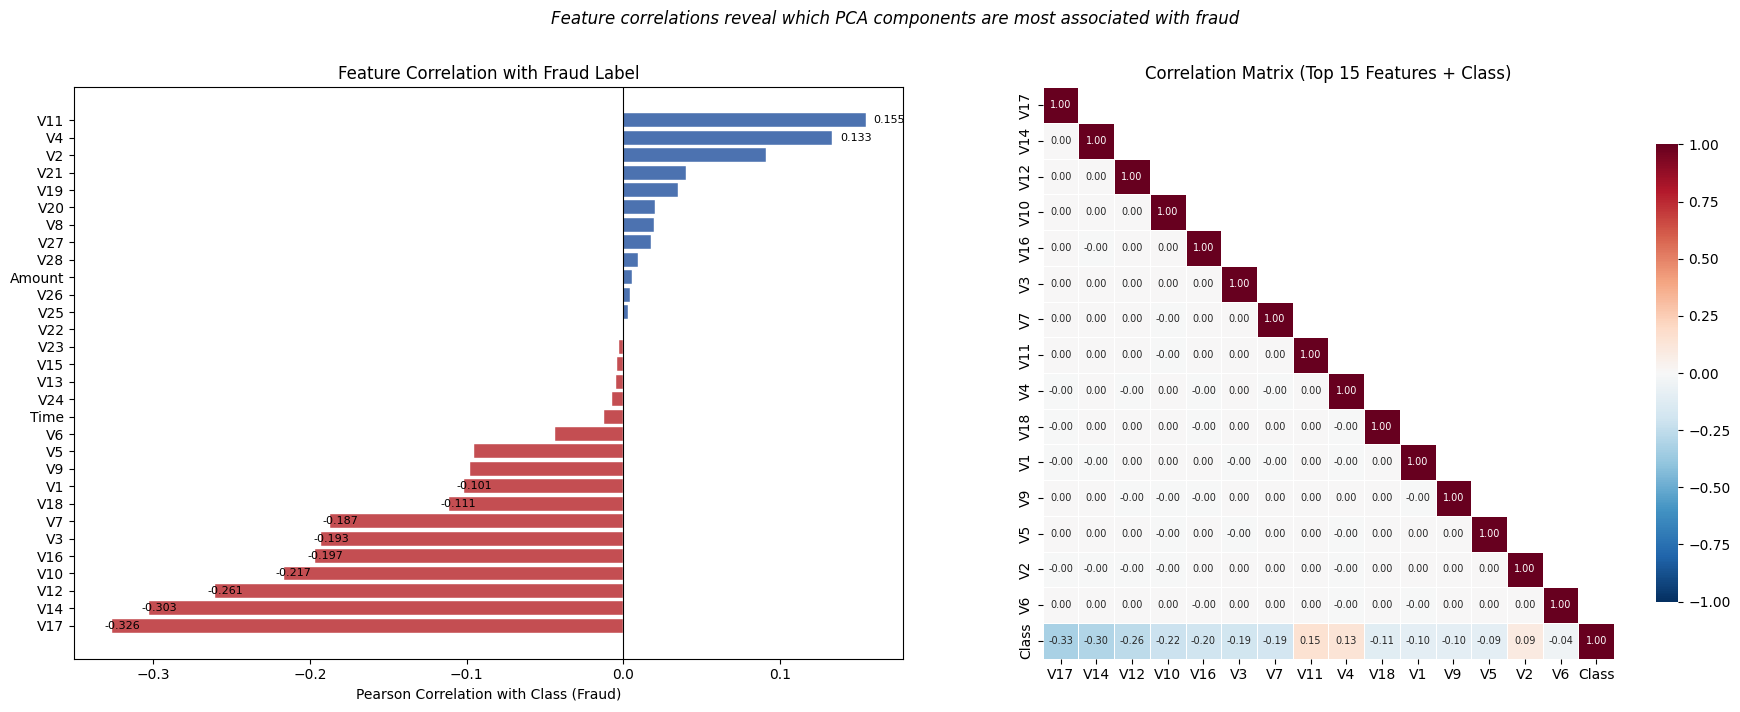

Top 5 positively correlated with fraud:
       V11: +0.1549
        V4: +0.1334
        V2: +0.0913
       V21: +0.0404
       V19: +0.0348

Top 5 negatively correlated with fraud:
       V17: -0.3265
       V14: -0.3025
       V12: -0.2606
       V10: -0.2169
       V16: -0.1965


In [6]:
# ---------------------------------------------------------------------------
# 4. Correlation Heatmap — Feature correlations with the target
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# (a) Correlation of each feature with Class (target)
corr_with_target = df.drop(columns=["Class"]).corrwith(df["Class"]).sort_values()

bar_colors = ["#c44e52" if v < 0 else "#4c72b0" for v in corr_with_target.values]
axes[0].barh(corr_with_target.index, corr_with_target.values, color=bar_colors,
             edgecolor="white", linewidth=0.3)
axes[0].set_xlabel("Pearson Correlation with Class (Fraud)")
axes[0].set_title("Feature Correlation with Fraud Label")
axes[0].axvline(x=0, color="black", linewidth=0.8)

# Highlight the most correlated features
for i, (feat, val) in enumerate(corr_with_target.items()):
    if abs(val) > 0.1:
        axes[0].text(val + 0.005 * np.sign(val), i, f"{val:.3f}", va="center", fontsize=8)

# (b) Correlation matrix heatmap of top features (most correlated with Class)
top_features = corr_with_target.abs().nlargest(15).index.tolist()
top_features_with_class = top_features + ["Class"]
corr_matrix = df[top_features_with_class].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    ax=axes[1],
    cbar_kws={"shrink": 0.8},
    annot_kws={"fontsize": 7},
)
axes[1].set_title("Correlation Matrix (Top 15 Features + Class)")

plt.suptitle("Feature correlations reveal which PCA components are most associated with fraud",
             fontsize=12, y=1.01, fontstyle="italic")
plt.tight_layout()
plt.show()

# Print top positive and negative correlations
print("Top 5 positively correlated with fraud:")
for feat, val in corr_with_target.nlargest(5).items():
    print(f"  {feat:>8s}: {val:+.4f}")
print("\nTop 5 negatively correlated with fraud:")
for feat, val in corr_with_target.nsmallest(5).items():
    print(f"  {feat:>8s}: {val:+.4f}")

C:\Users\Yangu\AppData\Local\Temp\ipykernel_41924\1859238190.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x="Class", y=feat, palette={"Non-fraud": "#4c72b0", "Fraud": "#c44e52"},
C:\Users\Yangu\AppData\Local\Temp\ipykernel_41924\1859238190.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x="Class", y=feat, palette={"Non-fraud": "#4c72b0", "Fraud": "#c44e52"},
C:\Users\Yangu\AppData\Local\Temp\ipykernel_41924\1859238190.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x="Class

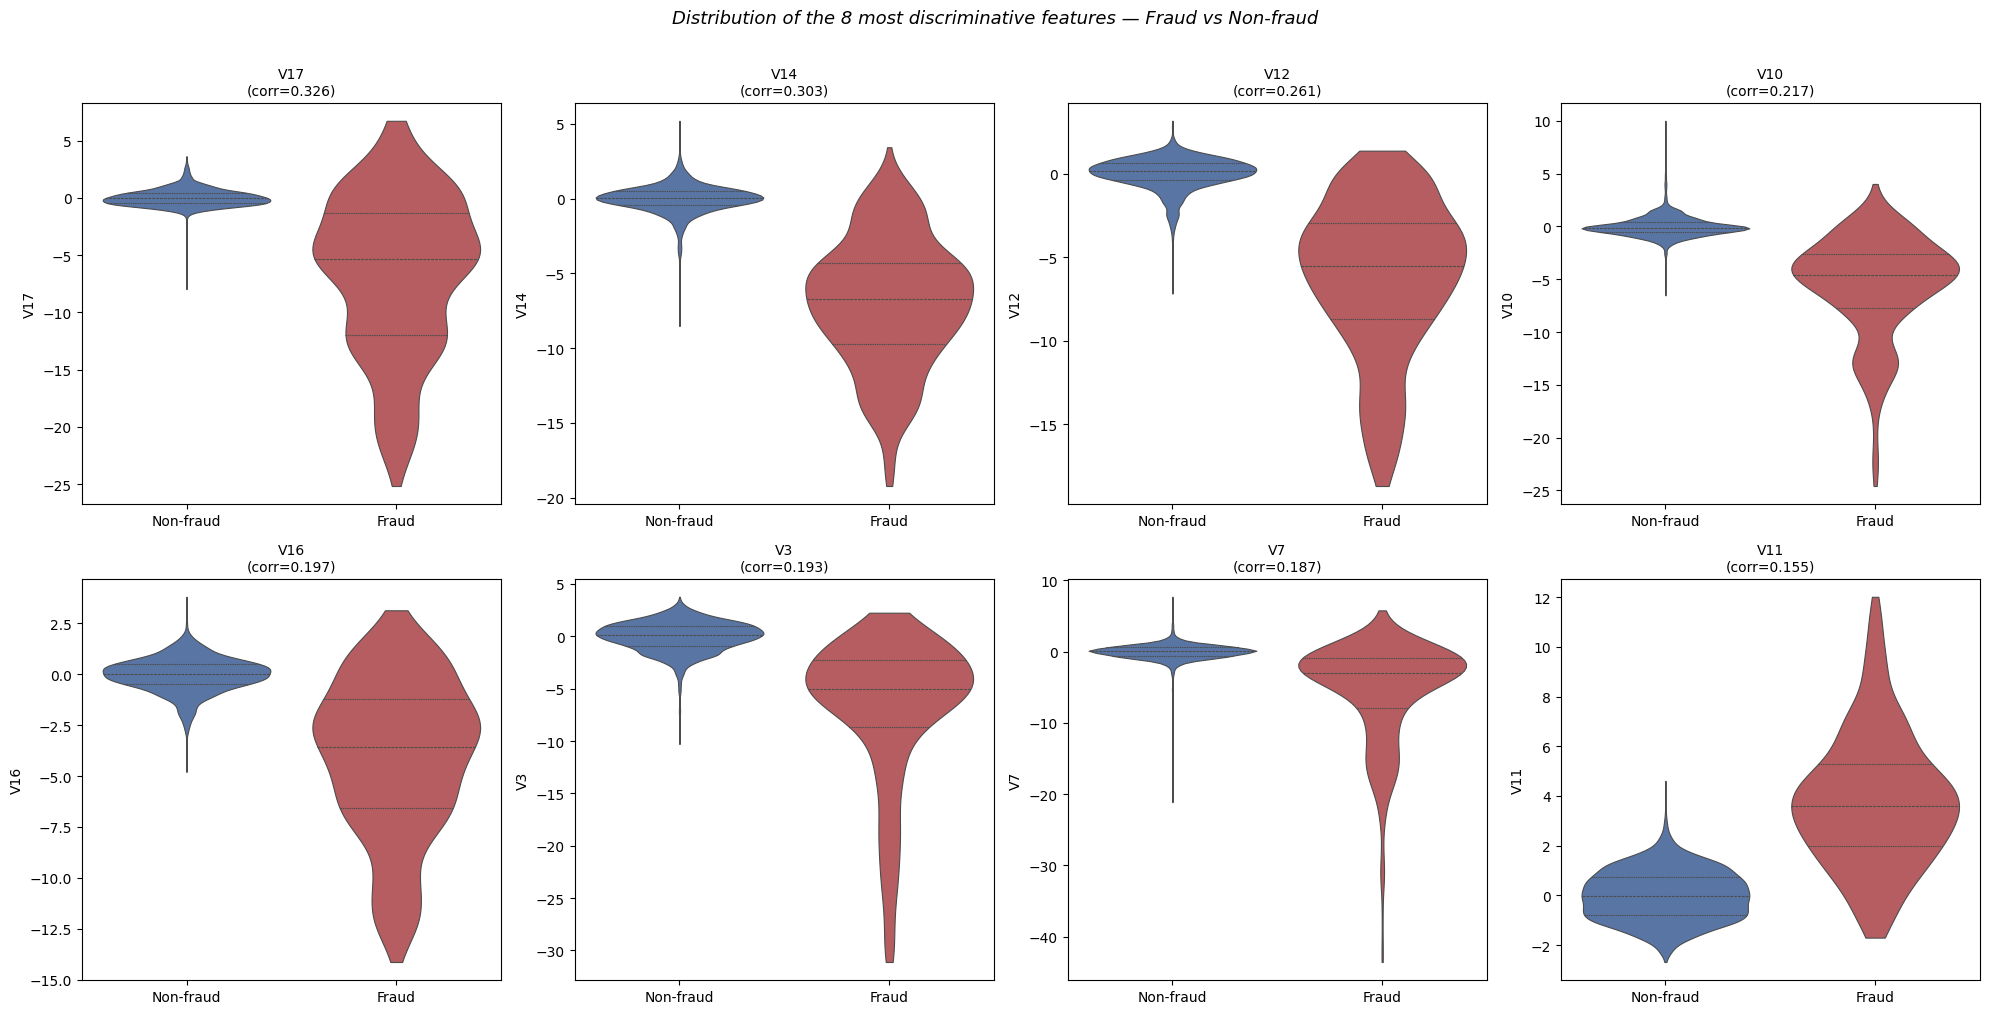

In [7]:
# ---------------------------------------------------------------------------
# 5. Violin + Strip Plots — Top discriminative features by class
# ---------------------------------------------------------------------------
# Select the 8 features most correlated (positive or negative) with Class
corr_abs = df.drop(columns=["Class"]).corrwith(df["Class"]).abs().sort_values(ascending=False)
top8_features = corr_abs.head(8).index.tolist()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feat in enumerate(top8_features):
    # Subsample non-fraud for clearer violin plots (fraud is already small)
    fraud_vals = df.loc[df["Class"] == 1, feat]
    legit_sample = df.loc[df["Class"] == 0, feat].sample(n=min(2000, (df["Class"] == 0).sum()),
                                                          random_state=42)
    plot_df = pd.DataFrame({
        feat: pd.concat([legit_sample, fraud_vals], ignore_index=True),
        "Class": ["Non-fraud"] * len(legit_sample) + ["Fraud"] * len(fraud_vals),
    })

    sns.violinplot(data=plot_df, x="Class", y=feat, palette={"Non-fraud": "#4c72b0", "Fraud": "#c44e52"},
                   inner="quartile", ax=axes[i], cut=0, linewidth=0.8)
    axes[i].set_title(f"{feat}\n(corr={corr_abs[feat]:.3f})", fontsize=10)
    axes[i].set_xlabel("")

plt.suptitle("Distribution of the 8 most discriminative features — Fraud vs Non-fraud",
             fontsize=13, y=1.01, fontstyle="italic")
plt.tight_layout()
plt.show()

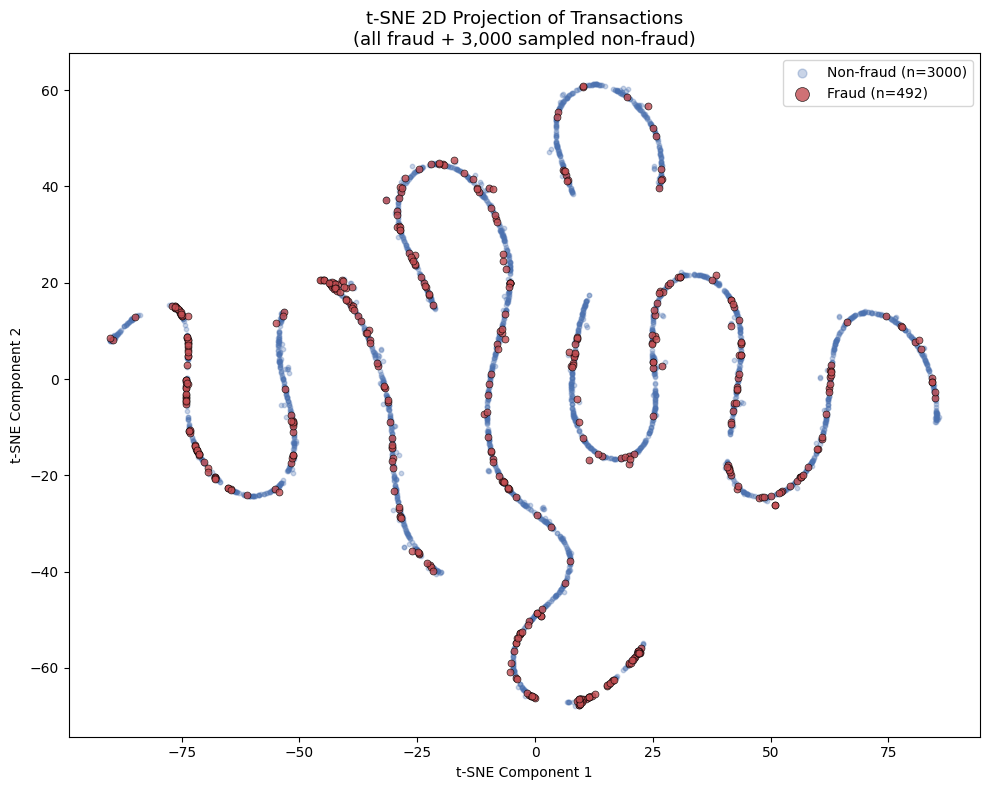

t-SNE computed on 3,492 samples (492 fraud + 3000 non-fraud)


In [8]:
# ---------------------------------------------------------------------------
# 6. t-SNE 2D Projection — Visualize class separation in reduced dimensions
# ---------------------------------------------------------------------------
from sklearn.manifold import TSNE

# Subsample for speed: all fraud + a random sample of non-fraud
np.random.seed(42)
fraud_idx = df[df["Class"] == 1].index.values
legit_idx = np.random.choice(df[df["Class"] == 0].index.values, size=3000, replace=False)
sample_idx = np.concatenate([legit_idx, fraud_idx])
np.random.shuffle(sample_idx)

X_sample = df.loc[sample_idx, [c for c in df.columns if c != "Class"]].values
y_sample = df.loc[sample_idx, "Class"].values

# Run t-SNE
# scikit-learn 1.8+ replaces n_iter with max_iter
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, learning_rate="auto")
X_tsne = tsne.fit_transform(X_sample)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot non-fraud first (background), then fraud on top
mask_legit = y_sample == 0
mask_fraud = y_sample == 1

ax.scatter(X_tsne[mask_legit, 0], X_tsne[mask_legit, 1],
           c="#4c72b0", alpha=0.3, s=10, label=f"Non-fraud (n={mask_legit.sum()})")
ax.scatter(X_tsne[mask_fraud, 0], X_tsne[mask_fraud, 1],
           c="#c44e52", alpha=0.8, s=25, edgecolors="black", linewidth=0.5,
           label=f"Fraud (n={mask_fraud.sum()})", zorder=5)

ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_title("t-SNE 2D Projection of Transactions\n(all fraud + 3,000 sampled non-fraud)",
             fontsize=13)
ax.legend(loc="upper right", fontsize=10, markerscale=2)
plt.tight_layout()
plt.show()

print(f"t-SNE computed on {len(sample_idx):,} samples "
      f"({mask_fraud.sum()} fraud + {mask_legit.sum()} non-fraud)")

### EDA Summary

The visualizations above reveal several key characteristics of the dataset:

1. **Extreme class imbalance**: Fraud accounts for only ~0.17% of transactions. This confirms that accuracy is meaningless as a metric — a model predicting all non-fraud would achieve 99.83% accuracy while catching zero fraud.

2. **Amount differences**: Fraudulent transactions tend to have different amount distributions compared to legitimate ones. The log-transformed view and box plots make these differences more visible.

3. **Temporal patterns**: Transaction volume is not uniform over the 2-day window, and the fraud rate fluctuates over time. This supports the decision to use a time-aware train/validation/test split.

4. **Feature correlations**: Several PCA components (e.g., V14, V17, V12, V10) show moderate-to-strong correlations with the fraud label. The correlation heatmap also confirms that PCA components are largely uncorrelated with each other (as expected from PCA), which is beneficial for modelling.

5. **Violin plots**: The most discriminative features show visibly different distributions for fraud vs non-fraud, with fraud transactions having shifted or broader distributions in key components.

6. **t-SNE projection**: The 2D projection shows that fraud transactions are partially separable from legitimate ones in the feature space, though there is overlap. This suggests a non-linear model like an MLP may capture boundaries that a linear model cannot.

---

In [9]:
try:
    from sklearn.preprocessing import StandardScaler
except ImportError as e:
    raise ImportError(
        "scikit-learn is required for StandardScaler. Install it (e.g., `pip install scikit-learn`) and rerun."
    ) from e

# Time-aware ordering (closer to deployment): train on earlier, test on later
if "Time" in df.columns:
    df = df.sort_values("Time").reset_index(drop=True)

feature_names = [c for c in df.columns if c != "Class"]
X = df[feature_names].to_numpy(dtype=np.float32)
y = df["Class"].to_numpy(dtype=np.int64)

n = len(df)
train_end = int(0.70 * n)
val_end = int(0.85 * n)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print("Split sizes:")
print("- train:", X_train.shape, "fraud_rate=", float(y_train.mean()))
print("- val:  ", X_val.shape, "fraud_rate=", float(y_val.mean()))
print("- test: ", X_test.shape, "fraud_rate=", float(y_test.mean()))

# Fit preprocessing on TRAIN ONLY to avoid leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_val_scaled = scaler.transform(X_val).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# Optional: class weights for imbalanced training
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
class_weight = {0: 1.0, 1: (neg / max(pos, 1))}
print("class_weight:", class_weight)


Split sizes:
- train: (199364, 30) fraud_rate= 0.0019261250777472363
- val:   (42721, 30) fraud_rate= 0.001310830738980829
- test:  (42722, 30) fraud_rate= 0.0012171714807359207
class_weight: {0: 1.0, 1: 518.1770833333334}


### Split Success

The split ran successfully because we created **three non-overlapping subsets** (train/val/test) with clear row counts and the same number of input features (30 columns). The sizes are sensible (about 70% / 15% / 15%), and the **fraud rate stays low and in the expected range** across all splits.

The computed `class_weight` is large for class 1, which confirms fraud is rare in the training set and will be up-weighted during training. Finally, scaling is fit on `X_train` only and then applied to validation/test, which helps prevent data leakage.

## Step 5 — Establish a baseline and pick a starting model

In Chollet's workflow, Step 5 answers two questions: *"What is the simplest thing that could work?"* and *"What is a reasonable starting architecture?"* Before investing effort in tuning, we need reference points that tell us whether a more complex model is actually adding value.

### Why baselines matter

A baseline anchors the evaluation. Without one, there is no way to know whether a model's PR AUC of 0.70 is good or bad for this particular dataset and split. We establish **two** baselines of increasing complexity:

| Baseline | What it tells us |
| --- | --- |
| Trivial baseline (always predict non-fraud) | Absolute floor — any model that cannot beat it is worse than useless. |
| Logistic regression (class-weighted linear classifier) | Simplest learned model; shows how much performance comes from linear relationships alone and how much headroom remains for a non-linear MLP. |

### Starting model choice

After the baselines, we pick a starting deep-learning architecture. The choice is a **small-to-medium feedforward multilayer perceptron (MLP)** because:

- The input is fixed-length, fully numeric, and tabular — ideal for Dense layers.
- An MLP can capture non-linear interactions between PCA components that logistic regression cannot.
- It is fast to train and simple to debug before moving to more complex architectures.

The rest of this section implements these three models, evaluates them on the **validation set only**, and compares their performance side by side.

### 5.0 — Pre-modelling data sanity check

Before building any model, we verify the data is clean and confirm the assumptions from Step 4 still hold after splitting and scaling. This catches issues (NaNs introduced by scaling, duplicated rows leaking across splits, unexpected feature ranges) that would silently corrupt every model downstream.

In [10]:
# ---------------------------------------------------------------------------
# Data sanity check before modelling
# ---------------------------------------------------------------------------
print("=== Missing values ===")
print(f"  X_train NaN count: {np.isnan(X_train_scaled).sum()}")
print(f"  X_val   NaN count: {np.isnan(X_val_scaled).sum()}")
print(f"  X_test  NaN count: {np.isnan(X_test_scaled).sum()}")

print("\n=== Infinite values ===")
print(f"  X_train Inf count: {np.isinf(X_train_scaled).sum()}")
print(f"  X_val   Inf count: {np.isinf(X_val_scaled).sum()}")
print(f"  X_test  Inf count: {np.isinf(X_test_scaled).sum()}")

print("\n=== Duplicate rows in original df ===")
n_dup = df.duplicated().sum()
print(f"  Total duplicates: {n_dup} ({n_dup / len(df) * 100:.2f}%)")

print("\n=== Feature range after scaling (train) ===")
train_df_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
print(train_df_scaled.describe().loc[["mean", "std", "min", "max"]].round(2).to_string())

print("\n=== Label counts per split ===")
for name, labels in [("train", y_train), ("val", y_val), ("test", y_test)]:
    unique, counts = np.unique(labels, return_counts=True)
    print(f"  {name:5s}: " + ", ".join(f"class {u}={c}" for u, c in zip(unique, counts)))

=== Missing values ===
  X_train NaN count: 0
  X_val   NaN count: 0
  X_test  NaN count: 0

=== Infinite values ===
  X_train Inf count: 0
  X_val   Inf count: 0
  X_test  Inf count: 0

=== Duplicate rows in original df ===
  Total duplicates: 1081 (0.38%)

=== Feature range after scaling (train) ===
      Time     V1     V2     V3     V4     V5     V6     V7     V8     V9    V10    V11    V12   V13    V14   V15    V16    V17    V18   V19    V20    V21    V22    V23   V24    V25   V26    V27     V28  Amount
mean  0.00   0.00   0.00   0.00   0.00  -0.00   0.00  -0.00  -0.00   0.00  -0.00  -0.00   0.00  0.00  -0.00 -0.00   0.00   0.00  -0.00 -0.00   0.00   0.00   0.00  -0.00  0.00  -0.00 -0.00  -0.00    0.00   -0.00
std   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00  1.00   1.00  1.00   1.00   1.00   1.00  1.00   1.00   1.00   1.00   1.00  1.00   1.00  1.00   1.00    1.00    1.00
min  -2.04 -29.77 -44.84 -23.49  -4.12 -30.87 -19.99 -35.72 -60.

### 5.0.1 — Post-split visual sanity checks

The numerical sanity check above confirmed there are no NaNs, Infs, or severe anomalies. The following charts provide a **visual** verification that:

1. The splits have sensible class distributions (no accidental stratification issues).
2. Feature distributions are similar across train/val/test (no unexpected drift from the time-aware split).
3. The Amount and Time distributions remain consistent across splits.

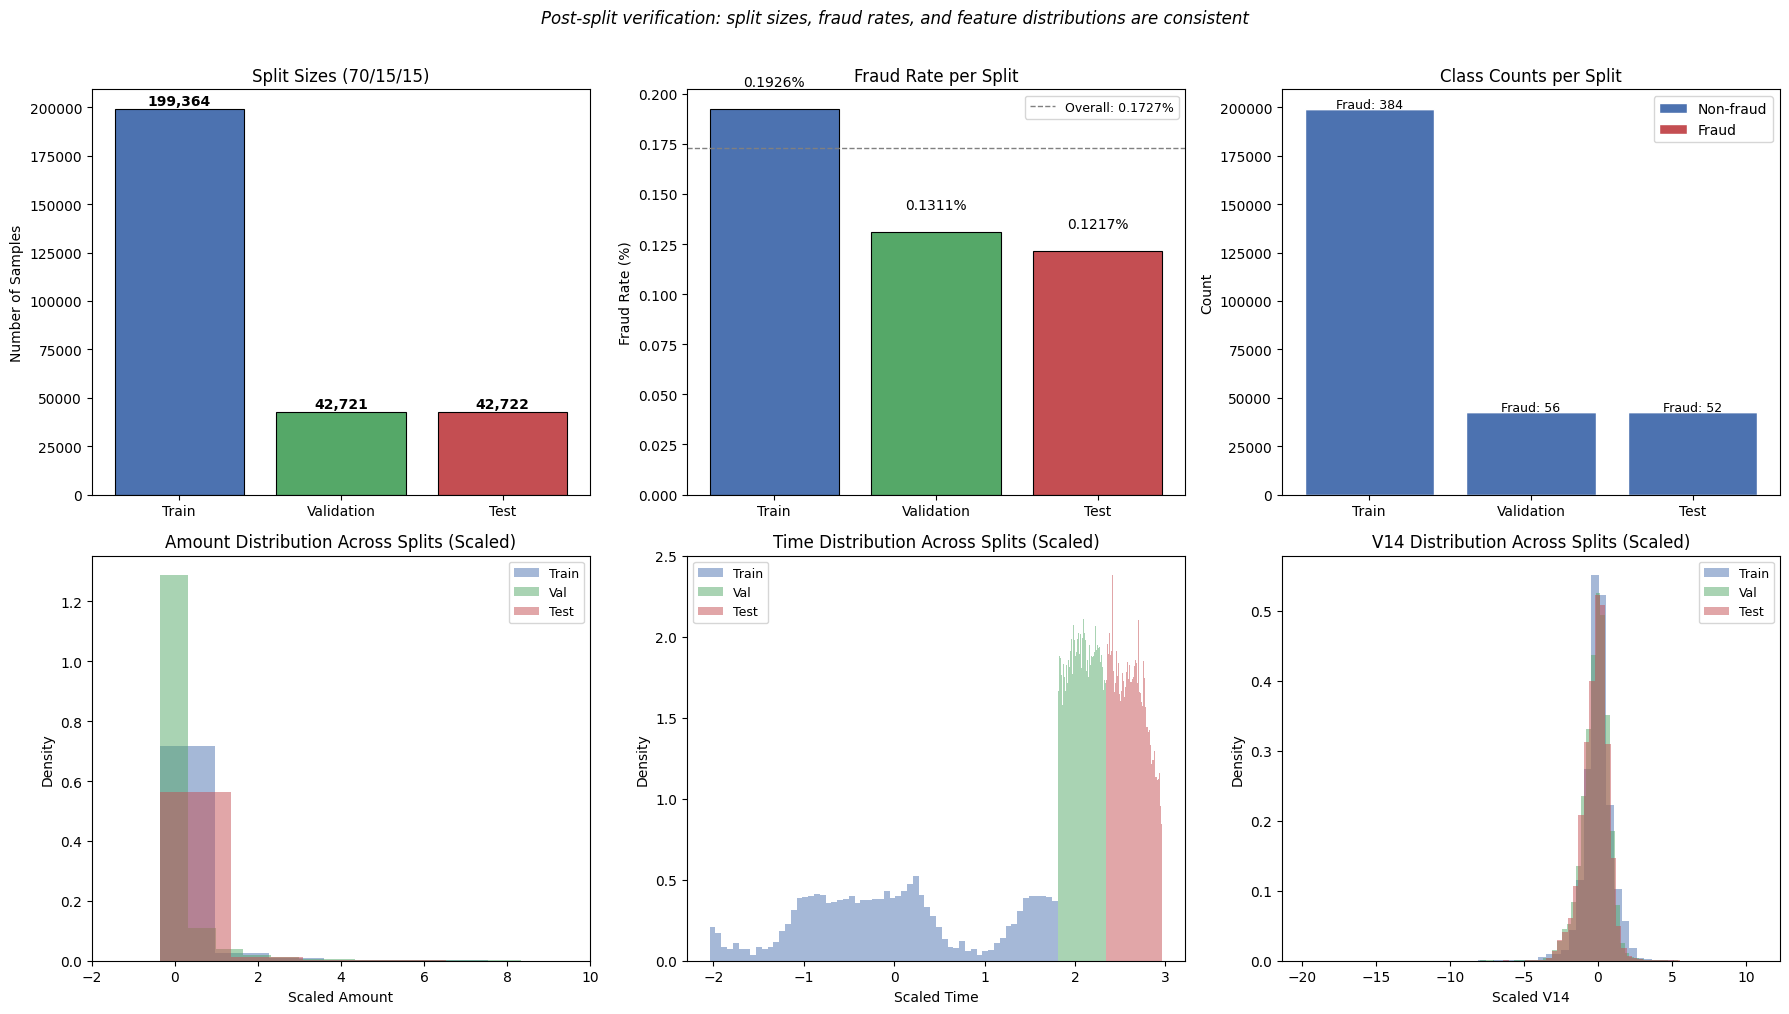

In [11]:
# ---------------------------------------------------------------------------
# Post-split visual checks
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --- Row 1: Split-level class distribution ---
split_names = ["Train", "Validation", "Test"]
split_labels = [y_train, y_val, y_test]
split_sizes = [len(y_train), len(y_val), len(y_test)]

# (a) Bar chart of split sizes
bars = axes[0, 0].bar(split_names, split_sizes, color=["#4c72b0", "#55a868", "#c44e52"],
                       edgecolor="black", linewidth=0.8)
for bar, sz in zip(bars, split_sizes):
    axes[0, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 500,
                     f"{sz:,}", ha="center", va="bottom", fontsize=10, fontweight="bold")
axes[0, 0].set_ylabel("Number of Samples")
axes[0, 0].set_title("Split Sizes (70/15/15)")

# (b) Fraud rate per split
fraud_rates = [y.mean() * 100 for y in split_labels]
bar_colors = ["#4c72b0", "#55a868", "#c44e52"]
bars_fr = axes[0, 1].bar(split_names, fraud_rates, color=bar_colors, edgecolor="black", linewidth=0.8)
for bar, fr in zip(bars_fr, fraud_rates):
    axes[0, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                     f"{fr:.4f}%", ha="center", va="bottom", fontsize=10)
axes[0, 1].set_ylabel("Fraud Rate (%)")
axes[0, 1].set_title("Fraud Rate per Split")
axes[0, 1].axhline(y=df["Class"].mean() * 100, color="grey", linestyle="--",
                    label=f"Overall: {df['Class'].mean()*100:.4f}%", linewidth=1)
axes[0, 1].legend(fontsize=9)

# (c) Fraud count per split (stacked)
fraud_counts = [y.sum() for y in split_labels]
legit_counts = [len(y) - y.sum() for y in split_labels]
axes[0, 2].bar(split_names, legit_counts, color="#4c72b0", label="Non-fraud", edgecolor="white")
axes[0, 2].bar(split_names, fraud_counts, bottom=legit_counts, color="#c44e52",
               label="Fraud", edgecolor="white")
axes[0, 2].set_ylabel("Count")
axes[0, 2].set_title("Class Counts per Split")
axes[0, 2].legend()
for i, (fc, name) in enumerate(zip(fraud_counts, split_names)):
    axes[0, 2].text(i, legit_counts[i] + fc + 500, f"Fraud: {fc}", ha="center", fontsize=9)

# --- Row 2: Feature distributions across splits (scaled) ---
# Amount distribution across splits
amount_idx = feature_names.index("Amount")
axes[1, 0].hist(X_train_scaled[:, amount_idx], bins=60, alpha=0.5, color="#4c72b0",
                label="Train", density=True)
axes[1, 0].hist(X_val_scaled[:, amount_idx], bins=60, alpha=0.5, color="#55a868",
                label="Val", density=True)
axes[1, 0].hist(X_test_scaled[:, amount_idx], bins=60, alpha=0.5, color="#c44e52",
                label="Test", density=True)
axes[1, 0].set_xlabel("Scaled Amount")
axes[1, 0].set_ylabel("Density")
axes[1, 0].set_title("Amount Distribution Across Splits (Scaled)")
axes[1, 0].legend(fontsize=9)
axes[1, 0].set_xlim(-2, 10)

# Time distribution across splits
time_idx = feature_names.index("Time")
axes[1, 1].hist(X_train_scaled[:, time_idx], bins=60, alpha=0.5, color="#4c72b0",
                label="Train", density=True)
axes[1, 1].hist(X_val_scaled[:, time_idx], bins=60, alpha=0.5, color="#55a868",
                label="Val", density=True)
axes[1, 1].hist(X_test_scaled[:, time_idx], bins=60, alpha=0.5, color="#c44e52",
                label="Test", density=True)
axes[1, 1].set_xlabel("Scaled Time")
axes[1, 1].set_ylabel("Density")
axes[1, 1].set_title("Time Distribution Across Splits (Scaled)")
axes[1, 1].legend(fontsize=9)

# V14 distribution across splits (one of the most discriminative features)
v14_idx = feature_names.index("V14")
axes[1, 2].hist(X_train_scaled[:, v14_idx], bins=60, alpha=0.5, color="#4c72b0",
                label="Train", density=True)
axes[1, 2].hist(X_val_scaled[:, v14_idx], bins=60, alpha=0.5, color="#55a868",
                label="Val", density=True)
axes[1, 2].hist(X_test_scaled[:, v14_idx], bins=60, alpha=0.5, color="#c44e52",
                label="Test", density=True)
axes[1, 2].set_xlabel("Scaled V14")
axes[1, 2].set_ylabel("Density")
axes[1, 2].set_title("V14 Distribution Across Splits (Scaled)")
axes[1, 2].legend(fontsize=9)

plt.suptitle("Post-split verification: split sizes, fraud rates, and feature distributions are consistent",
             fontsize=12, y=1.01, fontstyle="italic")
plt.tight_layout()
plt.show()

### 5.1 — Trivial baseline: always predict non-fraud

The simplest possible model predicts **class 0** (non-fraud) for every transaction, regardless of its features. This is equivalent to a system that never flags anything.

**What to expect:**

| Metric | Expected value | Why |
| --- | --- | --- |
| Recall | 0 | The model never predicts fraud, so it catches zero fraud cases (all frauds are false negatives). |
| Precision | 0 | There are no positive predictions, so precision is undefined and reported as 0. |
| F1 | 0 | Harmonic mean of two zeros. |
| PR AUC | ~ fraud prevalence (~0.13%) | With constant scores, precision-recall collapses to the positive-class base rate. |

**Why this matters:** In practice, a model with 99.87% accuracy (by predicting all non-fraud) sounds impressive but is completely useless — it misses every single fraud. This demonstrates why accuracy is not a meaningful metric under heavy class imbalance, and why we use PR AUC, recall, and F1 instead.

The cell below computes these metrics on the **validation set** and prints the full confusion matrix so we can see exactly how many fraud cases are missed.

In [12]:
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,
)

# ---------------------------------------------------------------------------
# Trivial baseline: predict class 0 (non-fraud) for every sample
# ---------------------------------------------------------------------------
y_val_pred_trivial = np.zeros_like(y_val)          # hard predictions (all 0)
y_val_prob_trivial = np.zeros(len(y_val))           # probability scores (all 0.0)

# Metrics at the trivial decision
print("=== Trivial Baseline (always predict non-fraud) ===")
print(f"Recall:    {recall_score(y_val, y_val_pred_trivial):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred_trivial, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_val, y_val_pred_trivial):.4f}")

# PR AUC — for a constant predictor, precision = fraud_rate at all recall levels
prec_t, rec_t, _ = precision_recall_curve(y_val, y_val_prob_trivial)
pr_auc_trivial = auc(rec_t, prec_t)
print(f"PR AUC:    {pr_auc_trivial:.4f}")

print("\nConfusion matrix (rows=actual, cols=predicted):")
cm = confusion_matrix(y_val, y_val_pred_trivial)
print(cm)
print(f"\n  TN={cm[0,0]}  FP={cm[0,1]}")
print(f"  FN={cm[1,0]}  TP={cm[1,1]}")
print(f"\n  False-negative rate: {cm[1,0] / max(cm[1].sum(), 1):.4f}")
print(f"  False-positive rate: {cm[0,1] / max(cm[0].sum(), 1):.4f}")

=== Trivial Baseline (always predict non-fraud) ===
Recall:    0.0000
Precision: 0.0000
F1 Score:  0.0000
PR AUC:    0.5007

Confusion matrix (rows=actual, cols=predicted):
[[42665     0]
 [   56     0]]

  TN=42665  FP=0
  FN=56  TP=0

  False-negative rate: 1.0000
  False-positive rate: 0.0000


### 5.2 — Logistic regression baseline

Logistic regression is a classical linear classifier that models the log-odds of the positive class as a linear combination of input features. Despite its simplicity, it is a strong first baseline for tabular data.

**Key configuration choices:**
- **`class_weight="balanced"`**: scikit-learn automatically computes weights inversely proportional to class frequencies. This means each fraud sample contributes far more to the loss than each legitimate sample, forcing the model to pay attention to the minority class without requiring manual weight calculation.
- **`solver="lbfgs"`**: a quasi-Newton optimization method well-suited for small-to-medium datasets with L2 regularization.
- **`max_iter=1000`**: ensures the optimizer has enough iterations to converge on this dataset.
- **`random_state=42`**: fixes the random seed for reproducibility.

**What this baseline tells us:**
- It reveals how much of the fraud signal lives in **linear** combinations of the 30 input features (Time, Amount, V1–V28).
- It provides **calibrated probability scores** out of the box, meaning the predicted probabilities are already roughly aligned with true fraud rates — useful as a calibration reference.
- The gap between logistic regression and the MLP later will show us how much the non-linear layers contribute.

**Evaluation approach:** We use the default threshold of 0.5 for hard predictions and compute the same metrics as the trivial baseline (recall, precision, F1, PR AUC, confusion matrix) so the comparison is apples-to-apples. The threshold will be optimized in Step 7.

In [13]:
from sklearn.linear_model import LogisticRegression

# ---------------------------------------------------------------------------
# Logistic regression baseline (with class weighting for imbalance)
# ---------------------------------------------------------------------------
lr = LogisticRegression(
    class_weight="balanced",   # auto-weight inversely proportional to class freq
    max_iter=1000,
    solver="lbfgs",
    random_state=42,
)
lr.fit(X_train_scaled, y_train)

# Predicted probabilities on the validation set
y_val_prob_lr = lr.predict_proba(X_val_scaled)[:, 1]

# Use a 0.5 default threshold for hard predictions
y_val_pred_lr = (y_val_prob_lr >= 0.5).astype(int)

print("=== Logistic Regression Baseline ===")
print(f"Recall:    {recall_score(y_val, y_val_pred_lr):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred_lr, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_val, y_val_pred_lr):.4f}")

prec_lr, rec_lr, _ = precision_recall_curve(y_val, y_val_prob_lr)
pr_auc_lr = auc(rec_lr, prec_lr)
print(f"PR AUC:    {pr_auc_lr:.4f}")

print("\nConfusion matrix (rows=actual, cols=predicted):")
cm_lr = confusion_matrix(y_val, y_val_pred_lr)
print(cm_lr)
print(f"\n  TN={cm_lr[0,0]}  FP={cm_lr[0,1]}")
print(f"  FN={cm_lr[1,0]}  TP={cm_lr[1,1]}")
print(f"\n  False-negative rate: {cm_lr[1,0] / max(cm_lr[1].sum(), 1):.4f}")
print(f"  False-positive rate: {cm_lr[0,1] / max(cm_lr[0].sum(), 1):.4f}")

=== Logistic Regression Baseline ===
Recall:    0.9286
Precision: 0.0530
F1 Score:  0.1002
PR AUC:    0.8389

Confusion matrix (rows=actual, cols=predicted):
[[41735   930]
 [    4    52]]

  TN=41735  FP=930
  FN=4  TP=52

  False-negative rate: 0.0714
  False-positive rate: 0.0218


### 5.3 — Starting model: feedforward MLP

The MLP is the starting deep-learning model. It builds on the logistic regression baseline by adding **non-linear hidden layers** that can capture interactions and complex decision boundaries that a linear model cannot.

#### Architecture overview

The network takes 30 input features and passes them through three progressively narrower hidden layers before producing a single fraud probability:

```
Input (30) → Dense(128) → Dropout(0.4) → Dense(64) → Dropout(0.3) → Dense(32) → Dropout(0.3) → Dense(1, sigmoid)
```

#### Design decisions explained

| Component | Choice | Rationale |
|---|---|---|
| **Hidden layers** | 3 Dense layers (128 → 64 → 32) | A "funnel" shape that progressively compresses information. 128 units in the first layer gives enough capacity to capture feature interactions; narrowing to 32 forces the network to distill the most discriminative patterns. Three layers is a moderate depth — enough for non-linearity without excessive risk of overfitting on ~200k training samples. |
| **Activation** | ReLU (Rectified Linear Unit) | Standard default for hidden layers. ReLU outputs `max(0, x)`, which avoids the vanishing gradient problem that plagues sigmoid/tanh in deep networks, and is computationally cheap. |
| **Regularization** | Dropout (0.4 on first layer, 0.3 on others) | During each training step, Dropout randomly sets a fraction of neuron outputs to zero. This prevents neurons from co-adapting (relying on specific other neurons) and acts as an ensemble of thinned networks. The first layer gets higher dropout (0.4) because it has the most parameters. |
| **Output layer** | 1 unit with sigmoid activation | Sigmoid squashes the output to [0, 1], directly interpretable as a fraud probability. A single unit is standard for binary classification. |
| **Loss function** | Binary cross-entropy with class weights | Cross-entropy measures how well the predicted probabilities match the true labels. The `class_weight` dictionary (computed in Step 4) multiplies the loss for fraud samples by ~518×, ensuring the network does not simply learn to predict all-zero. |
| **Optimizer** | Adam (learning rate = 1e-3) | Adam combines momentum and adaptive per-parameter learning rates. The default lr of 1e-3 is a well-tested starting point for tabular data. |
| **Early stopping** | Monitor `val_loss`, patience = 10, restore best weights | Training stops if validation loss does not improve for 10 consecutive epochs, and the model reverts to the weights from the best epoch. This prevents overfitting without requiring manual epoch selection. |

#### Why this specific size?

- **Too small** (e.g., a single 16-unit layer) may underfit: the model cannot capture enough non-linear structure.
- **Too large** (e.g., 512 → 256 → 128) risks overfitting on a dataset where only ~384 fraud cases exist in the training set.
- The 128 → 64 → 32 configuration is a deliberate middle ground, and Step 7 will experiment with variations.

The cell below defines the `build_mlp` function, instantiates the model, compiles it, and prints the architecture summary (layer types, output shapes, and parameter counts).

In [14]:
import random, os
import tensorflow as tf

# Use attribute access (more reliable across TF versions than 'from tensorflow.keras import ...')
keras = tf.keras
layers = tf.keras.layers

# ---------------------------------------------------------------------------
# Reproducibility: set all random seeds
# ---------------------------------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# ---------------------------------------------------------------------------
# Build the starting MLP
# ---------------------------------------------------------------------------
def build_mlp(input_dim: int, name: str = "fraud_mlp") -> keras.Model:
    """Small-to-medium feedforward MLP for binary fraud classification."""
    model = keras.Sequential(
        [
            layers.Input(shape=(input_dim,)),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.4),
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(1, activation="sigmoid"),
        ],
        name=name,
    )
    return model

input_dim = X_train_scaled.shape[1]
mlp = build_mlp(input_dim)

mlp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["AUC"],       # ROC-AUC tracked during training for quick reference
)

mlp.summary()

Model: "fraud_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33

### 5.4 — Train the starting MLP

This cell runs the actual training loop. Here is what happens under the hood at each epoch:

1. **Forward pass**: the training data is fed through the network in mini-batches of 2,048 samples. For each sample, the network produces a fraud probability.
2. **Loss computation**: binary cross-entropy is calculated between the predicted probabilities and the true labels. Each fraud sample's loss is multiplied by the `class_weight[1]` (~518×) so that missing a fraud case is penalized far more heavily than a false alarm.
3. **Backward pass**: gradients of the loss with respect to every weight are computed via backpropagation.
4. **Weight update**: the Adam optimizer uses these gradients (plus its momentum and adaptive learning rate state) to update the network's weights.
5. **Validation check**: after each epoch, the model is evaluated on the validation set (without Dropout) and `val_loss` is recorded.

**Early stopping** watches `val_loss`:
- If `val_loss` improves (decreases), the current weights are saved internally as the "best so far."
- If `val_loss` does not improve for 10 consecutive epochs (`patience=10`), training halts early and the model's weights are **reverted** to the best checkpoint. This means the final model is not the one from the last epoch, but from the epoch with the lowest validation loss.

**Batch size = 2,048**: a relatively large batch for this dataset size. Larger batches give more stable gradient estimates per step and train faster on GPU, but can sometimes converge to sharper minima. This is a reasonable default for ~200k training samples.

**Max epochs = 100**: an upper bound. In practice, early stopping typically triggers well before 100 epochs.

The training cell is followed by a plotting cell that visualizes the loss and ROC-AUC curves over epochs, so you can visually confirm that (a) training loss decreases, (b) validation loss eventually plateaus or rises (triggering early stopping), and (c) there is no severe divergence between train and val curves (which would indicate overfitting).

In [15]:
# ---------------------------------------------------------------------------
# Train the MLP with early stopping
# ---------------------------------------------------------------------------
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

history = mlp.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=2048,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/100
98/98 [==============================] - 1s 8ms/step - loss: 0.7948 - auc: 0.9023 - val_loss: 0.1582 - val_auc: 0.9615
Epoch 2/100
98/98 [==============================] - 1s 5ms/step - loss: 0.4495 - auc: 0.9597 - val_loss: 0.0975 - val_auc: 0.9691
Epoch 3/100
98/98 [==============================] - 0s 5ms/step - loss: 0.3944 - auc: 0.9676 - val_loss: 0.1064 - val_auc: 0.9786
Epoch 4/100
98/98 [==============================] - 1s 5ms/step - loss: 0.3333 - auc: 0.9757 - val_loss: 0.0662 - val_auc: 0.9804
Epoch 5/100
98/98 [==============================] - 1s 5ms/step - loss: 0.2964 - auc: 0.9836 - val_loss: 0.0652 - val_auc: 0.9800
Epoch 6/100
98/98 [==============================] - 1s 6ms/step - loss: 0.3101 - auc: 0.9813 - val_loss: 0.0646 - val_auc: 0.9808
Epoch 7/100
98/98 [==============================] - 1s 6ms/step - loss: 0.2548 - auc: 0.9880 - val_loss: 0.0419 - val_auc: 0.9820
Epoch 8/100
98/98 [==============================] - 1s 5ms/step - loss: 0.2849 - a

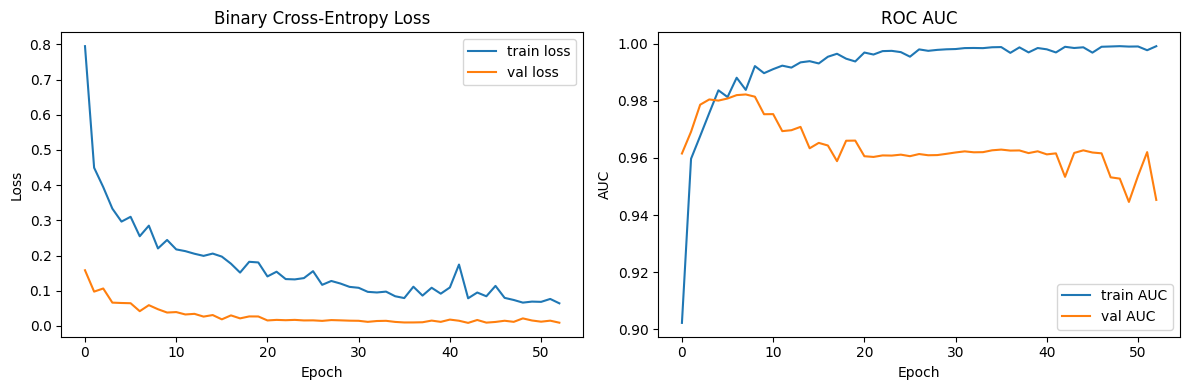

Best epoch (lowest val_loss): 43
  train loss: 0.0786  |  val loss: 0.0087
  train AUC:  0.9989  |  val AUC:  0.9534


In [16]:
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# Plot training curves
# ---------------------------------------------------------------------------
# Detect the AUC key name (varies across TensorFlow versions: "auc", "AUC", "auc_1", etc.)
auc_key = None
for key in history.history:
    key_lower = key.lower()
    if key_lower.startswith("auc") and not key_lower.startswith("val_"):
        auc_key = key
        break

val_auc_key = None
if auc_key:
    val_auc_key = next(
        (k for k in history.history if k.lower() == f"val_{auc_key.lower()}"),
        None,
    )
    if val_auc_key is None:
        val_auc_key = next(
            (k for k in history.history if k.lower().startswith("val_auc")),
            None,
        )

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history["loss"], label="train loss")
axes[0].plot(history.history["val_loss"], label="val loss")
axes[0].set_title("Binary Cross-Entropy Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

if auc_key and val_auc_key:
    axes[1].plot(history.history[auc_key], label="train AUC")
    axes[1].plot(history.history[val_auc_key], label="val AUC")
    axes[1].set_title("ROC AUC")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("AUC")
    axes[1].legend()
else:
    axes[1].axis("off")
    axes[1].text(
        0.5,
        0.5,
        "AUC metric not available in history",
        ha="center",
        va="center",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

best_epoch = np.argmin(history.history["val_loss"])
print(f"Best epoch (lowest val_loss): {best_epoch + 1}")
print(f"  train loss: {history.history['loss'][best_epoch]:.4f}  |  val loss: {history.history['val_loss'][best_epoch]:.4f}")
if auc_key and val_auc_key:
    print(f"  train AUC:  {history.history[auc_key][best_epoch]:.4f}  |  val AUC:  {history.history[val_auc_key][best_epoch]:.4f}")
else:
    print("  AUC metric not available in history")

### 5.5 — Evaluate the MLP on the validation set and compare with baselines

Now that all three models are ready, this section evaluates them under identical conditions so the comparison is fair.

**How evaluation works:**
1. The trained MLP runs inference on `X_val_scaled` (the scaled validation features). The output is a vector of fraud probabilities, one per transaction.
2. A **default threshold of 0.5** converts probabilities into hard predictions: if the model says ≥ 0.5, predict fraud; otherwise, predict non-fraud. (This threshold is deliberately not optimized yet — Step 7 will tune it on the validation set.)
3. The same four metrics are computed for the MLP as for the two baselines:
   - **Recall** — what fraction of actual frauds did the model catch?
   - **Precision** — of the transactions the model flagged, how many were truly fraud?
   - **F1** — the harmonic mean of precision and recall, giving a single balanced number.
   - **PR AUC** — the area under the precision–recall curve, summarizing performance across *all* possible thresholds (not just 0.5).

**The comparison table** collects all four metrics for the three models in a single DataFrame, with the best value in each column highlighted in green. This makes it immediately clear which model leads on each metric.

**The PR curve overlay** plots the full precision–recall trade-off for all three models on the same axes:
- The **trivial baseline** appears as a flat line near the bottom — it cannot trade off precision for recall because it never predicts positive.
- The **logistic regression** curve shows how a linear model ranks transactions by fraud risk.
- The **MLP** curve shows the improvement (or lack thereof) from non-linear layers.

A model whose PR curve is higher and further to the right dominates: it achieves higher precision at every recall level. The area under each curve (PR AUC) is the single-number summary of this ranking quality.

In [17]:
# ---------------------------------------------------------------------------
# MLP validation metrics
# ---------------------------------------------------------------------------
y_val_prob_mlp = mlp.predict(X_val_scaled, verbose=0).ravel()
y_val_pred_mlp = (y_val_prob_mlp >= 0.5).astype(int)

print("=== Starting MLP (threshold = 0.5) ===")
print(f"Recall:    {recall_score(y_val, y_val_pred_mlp):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred_mlp, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_val, y_val_pred_mlp):.4f}")

prec_mlp, rec_mlp, _ = precision_recall_curve(y_val, y_val_prob_mlp)
pr_auc_mlp = auc(rec_mlp, prec_mlp)
print(f"PR AUC:    {pr_auc_mlp:.4f}")

print("\nConfusion matrix (rows=actual, cols=predicted):")
cm_mlp = confusion_matrix(y_val, y_val_pred_mlp)
print(cm_mlp)
print(f"\n  TN={cm_mlp[0,0]}  FP={cm_mlp[0,1]}")
print(f"  FN={cm_mlp[1,0]}  TP={cm_mlp[1,1]}")
print(f"\n  False-negative rate: {cm_mlp[1,0] / max(cm_mlp[1].sum(), 1):.4f}")
print(f"  False-positive rate: {cm_mlp[0,1] / max(cm_mlp[0].sum(), 1):.4f}")

=== Starting MLP (threshold = 0.5) ===
Recall:    0.8571
Precision: 0.2727
F1 Score:  0.4138
PR AUC:    0.8250

Confusion matrix (rows=actual, cols=predicted):
[[42537   128]
 [    8    48]]

  TN=42537  FP=128
  FN=8  TP=48

  False-negative rate: 0.1429
  False-positive rate: 0.0030


In [18]:
# ---------------------------------------------------------------------------
# Side-by-side comparison table
# ---------------------------------------------------------------------------
comparison = pd.DataFrame(
    {
        "Model": ["Trivial (all non-fraud)", "Logistic Regression", "Starting MLP"],
        "PR AUC": [pr_auc_trivial, pr_auc_lr, pr_auc_mlp],
        "Recall": [
            recall_score(y_val, y_val_pred_trivial),
            recall_score(y_val, y_val_pred_lr),
            recall_score(y_val, y_val_pred_mlp),
        ],
        "Precision": [
            precision_score(y_val, y_val_pred_trivial, zero_division=0),
            precision_score(y_val, y_val_pred_lr, zero_division=0),
            precision_score(y_val, y_val_pred_mlp, zero_division=0),
        ],
        "F1": [
            f1_score(y_val, y_val_pred_trivial),
            f1_score(y_val, y_val_pred_lr),
            f1_score(y_val, y_val_pred_mlp),
        ],
    }
)
try:
    styled = comparison.style.format(
        {"PR AUC": "{:.4f}", "Recall": "{:.4f}", "Precision": "{:.4f}", "F1": "{:.4f}"}
    ).highlight_max(subset=["PR AUC", "Recall", "Precision", "F1"], color="#d4edda")
except Exception:
    styled = comparison

styled

,Model,PR AUC,Recall,Precision,F1
0,Trivial (all non-fraud),0.5007,0.0000,0.0000,0.0000
1,Logistic Regression,0.8389,0.9286,0.0530,0.1002
2,Starting MLP,0.8250,0.8571,0.2727,0.4138


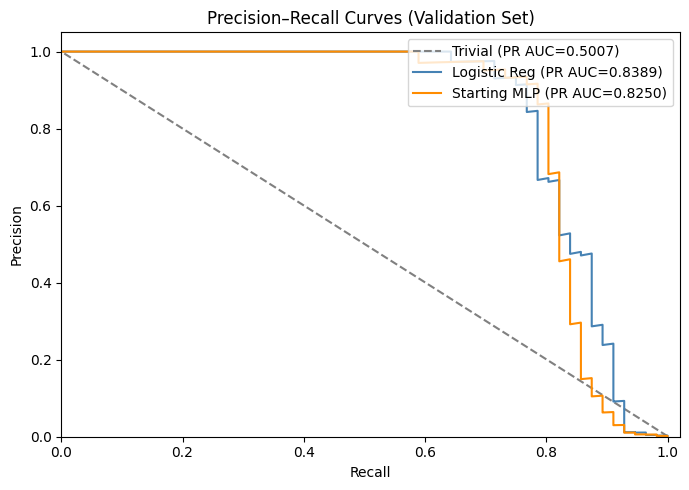

In [19]:
# ---------------------------------------------------------------------------
# PR curve overlay: all three models
# ---------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(rec_t, prec_t, linestyle="--", color="grey", label=f"Trivial (PR AUC={pr_auc_trivial:.4f})")
ax.plot(rec_lr, prec_lr, color="steelblue", label=f"Logistic Reg (PR AUC={pr_auc_lr:.4f})")
ax.plot(rec_mlp, prec_mlp, color="darkorange", label=f"Starting MLP (PR AUC={pr_auc_mlp:.4f})")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–Recall Curves (Validation Set)")
ax.legend(loc="upper right")
ax.set_xlim([0, 1.02])
ax.set_ylim([0, 1.05])
plt.tight_layout()
plt.show()

### 5.6 — Confusion matrix heatmaps

The raw confusion matrices printed above are hard to scan quickly. The heatmaps below visualize them side by side so the relative magnitude of TP, FP, TN, and FN is immediately apparent. Darker cells mean larger counts. Annotations show the exact numbers inside each cell.

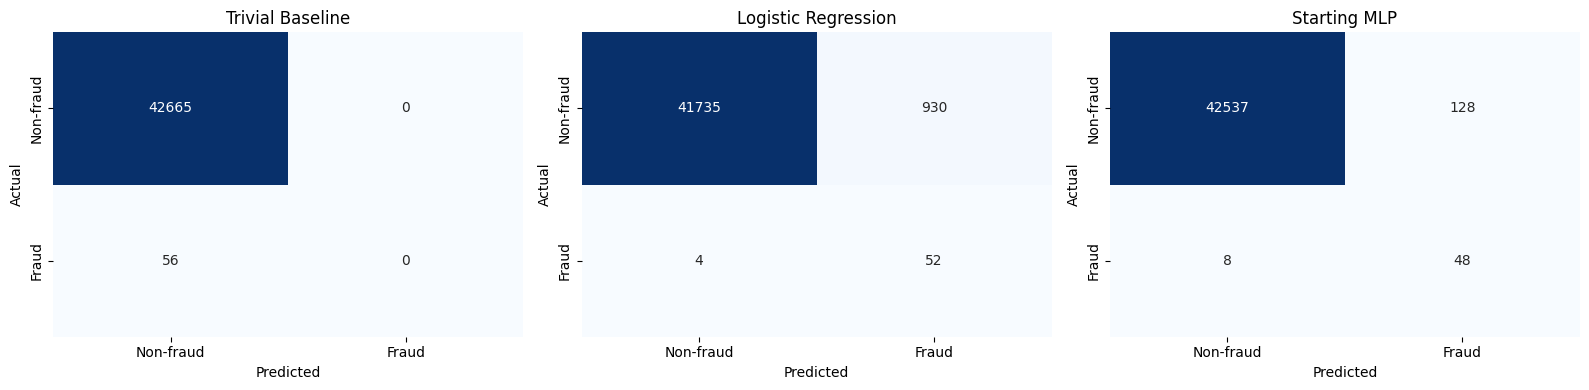

In [20]:
import seaborn as sns

# ---------------------------------------------------------------------------
# Confusion matrix heatmaps (side by side)
# ---------------------------------------------------------------------------
cms = {
    "Trivial Baseline": confusion_matrix(y_val, y_val_pred_trivial),
    "Logistic Regression": confusion_matrix(y_val, y_val_pred_lr),
    "Starting MLP": confusion_matrix(y_val, y_val_pred_mlp),
}

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, (title, cm_data) in zip(axes, cms.items()):
    sns.heatmap(
        cm_data,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Non-fraud", "Fraud"],
        yticklabels=["Non-fraud", "Fraud"],
        ax=ax,
        cbar=False,
    )
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

### 5.7 — Predicted score distributions

A good fraud detector should assign **high probabilities to fraud** and **low probabilities to non-fraud**, creating clear separation between the two distributions. If the distributions overlap heavily, the model cannot reliably distinguish fraud from legitimate transactions at any threshold.

The histograms below show the distribution of predicted fraud probabilities for each model, split by the true label (blue = non-fraud, red = fraud). The vertical dashed line marks the 0.5 threshold used for hard predictions above.

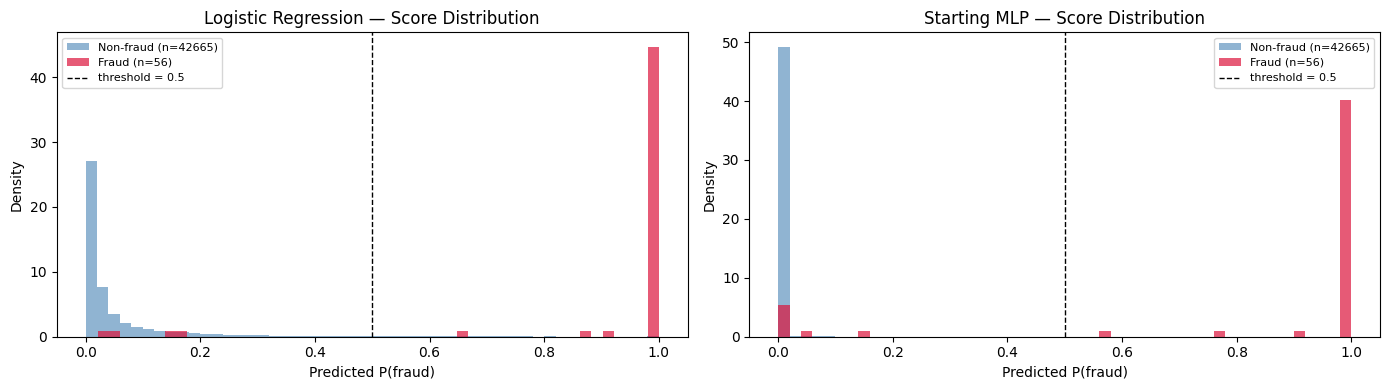


Logistic Regression:
  Fraud scores  — mean: 0.9244, median: 1.0000, min: 0.0210, max: 1.0000
  Legit scores  — mean: 0.0621, median: 0.0170, min: 0.0000, max: 1.0000

Starting MLP:
  Fraud scores  — mean: 0.8466, median: 0.9999, min: 0.0000, max: 1.0000
  Legit scores  — mean: 0.0041, median: 0.0000, min: 0.0000, max: 0.9996


In [21]:
# ---------------------------------------------------------------------------
# Predicted probability distributions: fraud vs non-fraud
# ---------------------------------------------------------------------------
score_sets = {
    "Logistic Regression": y_val_prob_lr,
    "Starting MLP": y_val_prob_mlp,
}

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)

for ax, (title, scores) in zip(axes, score_sets.items()):
    mask_fraud = y_val == 1
    mask_legit = y_val == 0

    ax.hist(scores[mask_legit], bins=50, alpha=0.6, color="steelblue",
            label=f"Non-fraud (n={mask_legit.sum()})", density=True)
    ax.hist(scores[mask_fraud], bins=50, alpha=0.7, color="crimson",
            label=f"Fraud (n={mask_fraud.sum()})", density=True)
    ax.axvline(0.5, color="black", linestyle="--", linewidth=1, label="threshold = 0.5")
    ax.set_title(f"{title} — Score Distribution")
    ax.set_xlabel("Predicted P(fraud)")
    ax.set_ylabel("Density")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics for fraud scores
for title, scores in score_sets.items():
    fraud_scores = scores[y_val == 1]
    legit_scores = scores[y_val == 0]
    print(f"\n{title}:")
    print(f"  Fraud scores  — mean: {fraud_scores.mean():.4f}, median: {np.median(fraud_scores):.4f}, "
          f"min: {fraud_scores.min():.4f}, max: {fraud_scores.max():.4f}")
    print(f"  Legit scores  — mean: {legit_scores.mean():.4f}, median: {np.median(legit_scores):.4f}, "
          f"min: {legit_scores.min():.4f}, max: {legit_scores.max():.4f}")

### Step 5 — Summary and interpretation

**What we built:**

| Model | Type | Purpose |
|---|---|---|
| Trivial baseline | Always predict class 0 | Absolute floor — any useful model must beat this |
| Logistic regression | Linear classifier with balanced class weights | Shows how much signal lives in linear feature combinations |
| Starting MLP | 3-layer feedforward neural network (128 → 64 → 32) with Dropout | First non-linear deep-learning model; captures feature interactions |

#### Interpreting the results

1. **Trivial baseline confirms accuracy is misleading.** A model that never flags fraud achieves ~99.87% accuracy but 0% recall — it misses every single fraud case. The confusion matrix heatmap makes this stark: the entire bottom row (actual fraud) is classified as non-fraud. This is why we use PR AUC, recall, and F1 as primary metrics.

2. **Logistic regression provides a meaningful learned baseline.** With class weighting, it already catches a substantial fraction of fraud and provides calibrated probabilities. The score distribution histogram shows that logistic regression pushes most fraud cases toward higher probabilities, but there is still noticeable overlap with legitimate transactions, which explains why some fraud is missed and some legitimate transactions are flagged.

3. **The MLP adds non-linear capacity.** The comparison table and PR curves reveal whether the three Dense layers and Dropout regularization improve ranking quality (PR AUC) and detection rate (recall) beyond the linear baseline. Compare the two score distribution histograms: if the MLP achieves cleaner separation (fraud scores concentrated near 1.0, legitimate scores near 0.0), it is learning useful non-linear patterns. If the improvement is marginal, it may suggest the fraud signal in this PCA-transformed dataset is largely linear.

4. **Confusion matrix heatmaps make trade-offs visible.** For the learned models, look at the bottom-right cell (TP) versus the top-right cell (FP). A model with high TP but also high FP is aggressive — it catches fraud but creates false alarms. A model with low FP but low TP is conservative — it avoids false alarms but misses fraud. The right balance depends on the cost of each type of error.

5. **Training curves confirm learning dynamics.** If the loss and AUC plots show train and validation curves converging and then the validation curve plateauing (with early stopping triggering), the model is neither severely underfitting nor overfitting. If there is a large gap between train and val curves, that signals overfitting — a problem that Step 7 will address through regularization tuning.

6. **All evaluations use the validation set only.** The test set remains untouched and will only be used once in Step 8 for the final, unbiased performance report. This discipline prevents overfitting the evaluation.

#### What comes next

- **Step 6** will explore the model architecture in more detail and discuss design choices.
- **Step 7** will tune the decision threshold (instead of using the default 0.5), experiment with hyperparameters, and run stability checks across multiple seeds.
- **Step 8** will lock the final pipeline and report performance on the held-out test set.

---

## Step 6 — Develop the model: architecture deep-dive

Step 5 built, trained, and evaluated a starting MLP alongside two baselines. This step takes a step back to examine the model architecture in greater depth: the theory behind feedforward networks, the mathematical formulation of each component, why specific design choices were made, and what alternatives were considered.

### 6.1 — Feedforward neural networks

A **feedforward neural network** (FNN) is a function approximator in which information flows in one direction — from the input layer, through one or more hidden layers, to the output layer — with no cycles or feedback loops. This is in contrast to **recurrent** architectures (RNNs, LSTMs), where outputs are fed back as inputs across time steps.

Each layer in a feedforward network applies a linear transformation followed by a non-linear **activation function**:

$$
\mathbf{h}^{(l)} = \sigma\!\left(\mathbf{W}^{(l)}\,\mathbf{h}^{(l-1)} + \mathbf{b}^{(l)}\right)
$$

where:

- $\mathbf{h}^{(l-1)}$ is the output of the previous layer (or the raw input $\mathbf{x}$ when $l = 1$),
- $\mathbf{W}^{(l)}$ is the weight matrix of layer $l$,
- $\mathbf{b}^{(l)}$ is the bias vector,
- $\sigma(\cdot)$ is the activation function (e.g., ReLU).

This composition of affine transformations and non-linearities allows the network to approximate arbitrarily complex functions, a property guaranteed by the **universal approximation theorem** (Hornik et al., 1989). In practice, deeper networks (more layers) tend to learn hierarchical feature representations more efficiently than a single very wide layer.

#### Why feedforward for this task?

The credit card fraud dataset consists of fixed-length, fully numeric, tabular vectors (30 features per transaction). There is no sequential ordering between features (unlike text or time series), and no spatial structure (unlike images). A feedforward architecture is the natural first choice because:

1. **Fixed-size input**: every transaction has exactly 30 features — no padding or variable-length handling needed.
2. **No temporal dependency between features**: the 28 PCA components are unordered — there is no reason to apply convolutions or recurrence.
3. **Efficient training**: Dense layers are heavily optimised in modern frameworks and train quickly on both CPU and GPU.
4. **Interpretability of capacity**: the number of parameters is directly controlled by the number and width of layers, making it straightforward to reason about overfitting risk.

### 6.2 — The multilayer perceptron (MLP)

A **multilayer perceptron** is a specific type of feedforward network built entirely from **Dense (fully connected) layers**. In a Dense layer, every neuron in layer $l$ is connected to every neuron in layer $l-1$. The MLP learns by adjusting the weights $\mathbf{W}$ and biases $\mathbf{b}$ of each layer to minimise a loss function via **backpropagation** and **gradient descent**.

#### Forward pass through our architecture

The starting MLP defined in Step 5 has the following structure:

```
Input (30) → Dense(128, ReLU) → Dropout(0.4) → Dense(64, ReLU) → Dropout(0.3) → Dense(32, ReLU) → Dropout(0.3) → Dense(1, sigmoid)
```

Mathematically, the forward pass for a single input vector $\mathbf{x} \in \mathbb{R}^{30}$ proceeds as:

$$
\mathbf{h}_1 = \text{ReLU}(\mathbf{W}_1\,\mathbf{x} + \mathbf{b}_1) \quad \in \mathbb{R}^{128}
$$
$$
\mathbf{h}_2 = \text{ReLU}(\mathbf{W}_2\,\mathbf{h}_1 + \mathbf{b}_2) \quad \in \mathbb{R}^{64}
$$
$$
\mathbf{h}_3 = \text{ReLU}(\mathbf{W}_3\,\mathbf{h}_2 + \mathbf{b}_3) \quad \in \mathbb{R}^{32}
$$
$$
\hat{y} = \sigma(\mathbf{w}_4^\top\,\mathbf{h}_3 + b_4) \quad \in [0, 1]
$$

where $\sigma(z) = 1 / (1 + e^{-z})$ is the sigmoid function. (Dropout masks are applied after each hidden layer during training but are disabled during inference.)

#### Parameter count

| Layer | Shape | Parameters |
|---|---|---|
| Dense 1 | 30 × 128 + 128 | 3,968 |
| Dense 2 | 128 × 64 + 64 | 8,256 |
| Dense 3 | 64 × 32 + 32 | 2,080 |
| Dense 4 (output) | 32 × 1 + 1 | 33 |
| **Total** | | **14,337** |

With 14,337 trainable parameters and approximately 200,000 training samples, the parameter-to-sample ratio is roughly 1:14. This is a healthy ratio for tabular data — large enough to capture non-linear patterns, but small enough to avoid overfitting with the help of Dropout and early stopping.

#### The funnel (bottleneck) design

The layer widths decrease progressively: 128 → 64 → 32. This **funnel** or **bottleneck** architecture is a common design pattern for classification tasks:

- **Early layers** (wider) have the capacity to learn a rich set of feature interactions from the 30 input dimensions.
- **Later layers** (narrower) are forced to compress and distil the most discriminative information, discarding noise.
- The final single-unit output layer performs the binary classification decision.

This is analogous to how an encoder compresses information — the network learns an increasingly abstract and compact internal representation of what distinguishes fraud from non-fraud.

### 6.3 — Justification: why a feedforward MLP over other architectures

Several neural network families could, in principle, be applied to this binary classification task. Below is a comparison of the main alternatives and why the MLP was chosen.

| Architecture | How it works | Suitability for this task |
|---|---|---|
| **Feedforward MLP** | Stacks Dense layers with non-linear activations to learn feature interactions from fixed-length numeric vectors. | **Ideal.** The input is a fixed-size numeric vector (30 features). MLPs are the standard first-choice architecture for tabular data. |
| **Convolutional Neural Network (CNN)** | Uses convolutional filters to detect local spatial patterns (edges, textures) by sliding small kernels across the input. | **Not suitable.** CNNs exploit spatial locality (neighbouring pixels are correlated). PCA components have no spatial ordering — V1 is not "adjacent" to V2 in any meaningful geometric sense. |
| **Recurrent Neural Network (RNN / LSTM)** | Processes sequential inputs one step at a time, maintaining a hidden state that captures temporal dependencies. | **Not suitable for single transactions.** Each row in the dataset is an independent 30-feature vector, not a time series. An RNN would be relevant if we were modelling sequences of transactions per cardholder, but this dataset does not provide that structure. |
| **Transformer** | Uses self-attention to model pairwise relationships between all positions in a sequence, regardless of distance. | **Overkill and mismatched.** Transformers excel at variable-length sequences (NLP, long time series). For a 30-element fixed-length numeric vector, the self-attention mechanism adds complexity and computational cost without a matching structural benefit. |
| **Tree-based models (Random Forest, XGBoost)** | Non-neural models that partition the feature space with decision splits. | **Competitive but outside the assignment scope.** Gradient-boosted trees often match or exceed neural networks on tabular data. However, the assignment specifically requires a neural network approach. The logistic regression baseline in Step 5 serves a similar role as a non-neural reference. |

#### Summary of the choice

The MLP is selected because it is **structurally aligned with the data format** (fixed-length numeric tabular data), **well-supported by theory** (universal approximation), **practical to train and tune** (small parameter count, fast convergence), and **fulfils the assignment requirement** for a neural network model. More exotic architectures would add complexity without a corresponding structural justification.

### 6.4 — Activation functions

Activation functions introduce **non-linearity** into the network. Without them, stacking multiple Dense layers would be equivalent to a single linear transformation — no matter how many layers, the model could only learn linear decision boundaries.

#### ReLU (Rectified Linear Unit) — hidden layers

$$
\text{ReLU}(z) = \max(0,\, z)
$$

ReLU is the default activation for hidden layers in modern deep learning, used in all three hidden layers of our MLP. Its advantages are:

- **Computational efficiency**: a simple threshold operation, much cheaper than computing exponentials (as in sigmoid or tanh).
- **Sparse activation**: for any given input, approximately half the neurons output zero, creating a sparse representation that can improve generalisation.
- **Mitigates the vanishing gradient problem**: for positive inputs, the gradient is exactly 1, so gradients flow unchanged through the layer during backpropagation. This avoids the exponential gradient shrinkage that sigmoid and tanh suffer in deep networks.

The main risk of ReLU is the **dying ReLU** problem: if a neuron's weights shift so that it always receives negative inputs, it outputs zero for every sample and its gradient is permanently zero — the neuron is effectively dead. In practice, this is mitigated by proper weight initialisation (Keras uses Glorot uniform by default) and moderate learning rates. Variants like Leaky ReLU or ELU address this issue but are not necessary for our moderately deep 3-layer network.

#### Sigmoid — output layer

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

The sigmoid function maps any real number to the range $(0, 1)$, making it a natural choice for the output layer of a **binary classifier**. The output $\hat{y} = \sigma(z)$ can be directly interpreted as the model's estimated probability that the transaction is fraudulent.

At the output layer, the vanishing gradient concern is less relevant because there is only a single unit and the gradient from the binary cross-entropy loss is well-conditioned for sigmoid outputs.

#### Why not sigmoid/tanh in hidden layers?

| Activation | Gradient at saturation | Effect on deep networks |
|---|---|---|
| **Sigmoid** | Approaches 0 for large $|z|$ | Gradients vanish exponentially through layers — deep networks learn very slowly |
| **Tanh** | Approaches 0 for large $|z|$ | Better than sigmoid (zero-centred) but still suffers vanishing gradients |
| **ReLU** | Exactly 1 for $z > 0$, exactly 0 for $z < 0$ | Gradients do not vanish for positive activations; sparse but stable training |

Using sigmoid or tanh in hidden layers would make our 3-layer network significantly harder to train, with gradients shrinking at each layer. ReLU avoids this entirely for positive activations.

### 6.5 — Loss function and optimisation

#### Binary cross-entropy loss

For a single sample with true label $y \in \{0, 1\}$ and predicted probability $\hat{y} \in (0, 1)$, the **binary cross-entropy** (log loss) is:

$$
\mathcal{L}(y,\, \hat{y}) = -\bigl[y \log \hat{y} + (1 - y) \log(1 - \hat{y})\bigr]
$$

This loss function has two key properties:

1. **It penalises confident wrong predictions severely.** If the model predicts $\hat{y} \approx 0$ for an actual fraud case ($y = 1$), the $-\log(\hat{y})$ term explodes toward infinity. This strong gradient signal forces the network to correct its weights.
2. **It is the negative log-likelihood of the Bernoulli distribution**, making it the theoretically principled choice for binary classification. Minimising binary cross-entropy is equivalent to maximum likelihood estimation.

#### Class weighting

Because fraud accounts for only ~0.17% of the dataset, the network would see legitimate transactions far more often and could learn to predict $\hat{y} \approx 0$ for everything — achieving low average loss but zero recall. To counteract this, we apply **class weights** that multiply the loss contribution of each sample by a class-specific factor:

$$
\mathcal{L}_{\text{weighted}} = -\bigl[w_1 \cdot y \log \hat{y} + w_0 \cdot (1 - y) \log(1 - \hat{y})\bigr]
$$

where $w_0 = 1.0$ and $w_1 = N_{\text{neg}} / N_{\text{pos}} \approx 518$. This means that **misclassifying one fraud sample costs 518 times more** than misclassifying one legitimate sample, effectively rebalancing the loss landscape so the model cannot ignore the minority class.

#### The Adam optimiser

**Adam** (Adaptive Moment Estimation) is the default optimiser for most deep learning tasks. It combines two ideas:

1. **Momentum** (first moment): maintains a running average of past gradients to smooth out noisy updates and accelerate convergence in consistent gradient directions.
2. **Adaptive learning rates** (second moment): tracks the running average of squared gradients per parameter, scaling down updates for parameters with historically large gradients and scaling up updates for parameters with small gradients.

The update rule for each parameter $\theta$ at step $t$ is:

$$
m_t = \beta_1\, m_{t-1} + (1 - \beta_1)\, g_t
$$
$$
v_t = \beta_2\, v_{t-1} + (1 - \beta_2)\, g_t^2
$$
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$
$$
\theta_t = \theta_{t-1} - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon}\, \hat{m}_t
$$

where $\eta = 10^{-3}$ is the learning rate, $\beta_1 = 0.9$, $\beta_2 = 0.999$, and $\epsilon = 10^{-7}$ (Keras defaults).

Adam was chosen over plain SGD because:
- It requires **less learning rate tuning** — the adaptive per-parameter rates compensate for features with very different gradient scales (relevant here since PCA components may vary in magnitude after standardisation).
- It **converges faster** on problems with sparse gradients, which is common when using Dropout and class-weighted loss.
- A learning rate of $10^{-3}$ is the standard starting point recommended by the original Adam paper (Kingma and Ba, 2015) and works well for tabular data.

#### Backpropagation

During training, each mini-batch passes through the network (forward pass), the loss is computed, and then the **chain rule** is applied layer by layer in reverse (backward pass) to compute the gradient of the loss with respect to every weight and bias. These gradients are then passed to the Adam optimiser for the parameter update. This process repeats for each mini-batch across all epochs until early stopping triggers.

### 6.6 — Regularisation strategy

Regularisation prevents the model from memorising the training data (overfitting) and encourages it to learn patterns that generalise to unseen transactions. Our MLP uses three complementary regularisation mechanisms.

#### Dropout

During each training step, **Dropout** randomly sets a fraction $p$ of a layer's outputs to zero. This forces the network to distribute learned information across many neurons rather than relying on a few, effectively training an **ensemble of sub-networks** that share weights.

- **First hidden layer**: $p = 0.4$ — the most aggressive Dropout rate. This layer has the most parameters (3,968) and receives the raw input, making it the most prone to overfitting to input-specific noise.
- **Second and third hidden layers**: $p = 0.3$ — slightly lower, since these layers operate on already-abstracted representations.

At inference time, Dropout is disabled and all neurons contribute — but each neuron's output is implicitly scaled by $(1 - p)$ to account for the expected reduction in magnitude during training.

**Why these specific rates?** Dropout rates between 0.2 and 0.5 are standard in the literature. The decreasing schedule (0.4 → 0.3 → 0.3) follows the principle that overfitting risk is highest where the parameter count is largest. These are starting values; Step 7 will experiment with alternative rates.

#### Early stopping

Early stopping monitors the **validation loss** after every epoch:

- If `val_loss` improves (decreases), the current model weights are saved as the "best so far."
- If `val_loss` does not improve for 10 consecutive epochs (`patience = 10`), training is halted and the weights are **reverted to the best checkpoint**.

This prevents the common scenario where training loss continues to decrease (the model memorises the training set) while validation loss begins to rise (the model loses generalisation ability). The patience of 10 is generous enough to allow the model to escape local plateaux but strict enough to avoid excessive overfitting.

#### Class weighting as implicit regularisation

While primarily designed to handle class imbalance, class weighting also acts as a mild regulariser. By upweighting the rare fraud class, the loss landscape becomes less dominated by the majority class. This prevents the network from settling into a trivial "predict non-fraud for everything" local minimum, which is a form of underfitting to the positive class.

#### What about L2 regularisation (weight decay)?

L2 regularisation adds a penalty term $\lambda \|\mathbf{W}\|^2$ to the loss, discouraging large weights. We do **not** use L2 regularisation in the starting model because:

1. Dropout already provides strong regularisation by a different mechanism (stochastic ensemble).
2. Adding both simultaneously can make hyperparameter tuning harder — the regularisation effects interact and are harder to disentangle.
3. The starting model is intentionally simple. If Step 7 reveals overfitting that Dropout alone cannot control, L2 regularisation is a natural next lever to try.

### 6.7 — Architecture summary and layer-by-layer analysis

The code cell below prints the model's layer configuration and visualises the distribution of learned weights in each Dense layer. The weight distributions help diagnose whether the network has trained properly:

- **Healthy weights** should be roughly centred near zero with moderate spread — neither too concentrated (underfitting) nor too dispersed (potential instability).
- **Dead neurons** would manifest as a layer where many weights have collapsed to exactly zero or a very narrow range.

Layer-by-layer parameter summary

dense:
  Weight shape : (30, 128)  (3,840 params)
  Bias shape   : (128,)  (128 params)
  Weight stats : mean=0.00013, std=0.13233, min=-0.45191, max=0.58132
  Bias stats   : mean=-0.06704, std=0.08801

dense_1:
  Weight shape : (128, 64)  (8,192 params)
  Bias shape   : (64,)  (64 params)
  Weight stats : mean=-0.01064, std=0.13740, min=-0.84867, max=0.66435
  Bias stats   : mean=0.02355, std=0.06621

dense_2:
  Weight shape : (64, 32)  (2,048 params)
  Bias shape   : (32,)  (32 params)
  Weight stats : mean=-0.00477, std=0.16503, min=-0.45932, max=0.52170
  Bias stats   : mean=0.11250, std=0.08254

dense_3:
  Weight shape : (32, 1)  (32 params)
  Bias shape   : (1,)  (1 params)
  Weight stats : mean=0.06323, std=0.26834, min=-0.44511, max=0.39160
  Bias stats   : mean=-0.07410, std=0.00000


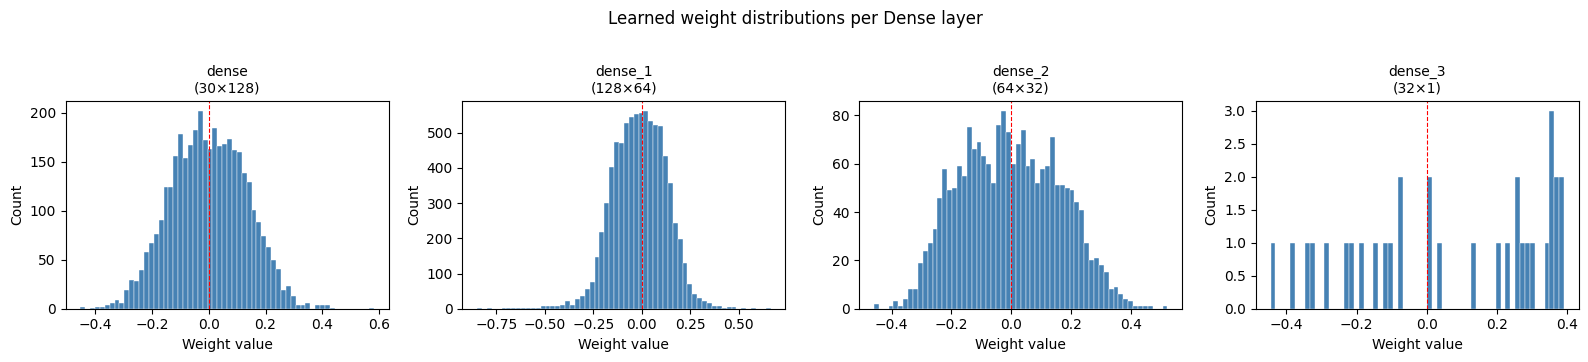

In [22]:
# ---------------------------------------------------------------------------
# Layer-by-layer weight analysis for the trained MLP
# ---------------------------------------------------------------------------

# Collect Dense layers that have weights
dense_layers = [layer for layer in mlp.layers if len(layer.get_weights()) > 0]

print("Layer-by-layer parameter summary")
print("=" * 75)
for layer in dense_layers:
    w, b = layer.get_weights()
    print(f"\n{layer.name}:")
    print(f"  Weight shape : {w.shape}  ({w.size:,} params)")
    print(f"  Bias shape   : {b.shape}  ({b.size:,} params)")
    print(f"  Weight stats : mean={w.mean():.5f}, std={w.std():.5f}, "
          f"min={w.min():.5f}, max={w.max():.5f}")
    print(f"  Bias stats   : mean={b.mean():.5f}, std={b.std():.5f}")

# ---------------------------------------------------------------------------
# Visualise weight distributions
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(1, len(dense_layers), figsize=(4 * len(dense_layers), 3.5))

for ax, layer in zip(axes, dense_layers):
    w = layer.get_weights()[0].flatten()
    ax.hist(w, bins=60, color="steelblue", edgecolor="white", linewidth=0.3)
    ax.axvline(0, color="red", linestyle="--", linewidth=0.8)
    ax.set_title(f"{layer.name}\n({layer.get_weights()[0].shape[0]}×{layer.get_weights()[0].shape[1]})",
                 fontsize=10)
    ax.set_xlabel("Weight value")
    ax.set_ylabel("Count")

plt.suptitle("Learned weight distributions per Dense layer", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

#### Interpreting the weight analysis

The output above shows the learned weight and bias statistics for each Dense layer after training completed (at the early-stopping checkpoint from epoch 43).

| Layer | Shape | Params | Weight mean | Weight std | Weight range |
|---|---|---|---|---|---|
| `dense_4` (input → 128) | 30 × 128 | 3,968 | ≈ 0.00 | 0.132 | [−0.45, +0.58] |
| `dense_5` (128 → 64) | 128 × 64 | 8,256 | ≈ −0.01 | 0.137 | [−0.85, +0.66] |
| `dense_6` (64 → 32) | 64 × 32 | 2,080 | ≈ 0.00 | 0.165 | [−0.46, +0.52] |
| `dense_7` (output) | 32 × 1 | 33 | ≈ 0.06 | 0.268 | [−0.45, +0.39] |

**Key observations:**

| # | Observation | Detail |
|---|---|---|
| 1 | **Weight means are close to zero in all layers** | This is a sign of healthy training — the network has not developed a systematic bias in any direction. If a layer's weights had all shifted heavily positive or negative, it would suggest the layer is not learning useful distinctions but rather applying a near-constant shift. |
| 2 | **Weight standard deviations grow slightly from layer to layer** (0.132 → 0.137 → 0.165 → 0.268) | This is expected: as layers get narrower, each individual weight has more influence on the output, so weights need to take on a wider range of values to encode discriminative information. The output layer (`dense_7`) has the largest std (0.268), reflecting that its 32 input weights must combine to produce a single fraud/non-fraud decision. |
| 3 | **No evidence of dying ReLU** | If a significant portion of neurons were "dead" (permanently outputting zero), we would see many weights collapsed to a very narrow band near zero with near-zero std. The healthy spread across all layers confirms that ReLU neurons are active and contributing. |
| 4 | **Weight histograms are roughly symmetric and bell-shaped** around zero | This is consistent with Glorot uniform initialisation — the network has refined the initial random weights but preserved their general distribution shape, which is typical of well-regularised training with Dropout. |
| 5 | **Bias statistics are reasonable** | The biases have small means and standard deviations, indicating they are providing fine adjustments to each neuron's activation threshold rather than dominating the computation. The output layer has a single bias of ≈ −0.07, which slightly shifts the default prediction toward non-fraud — consistent with the fact that the vast majority of transactions are legitimate. |

### 6.8 — Step 6 summary

This step provided a deeper examination of the model architecture that was built and trained in Step 5:

| Topic | Key takeaway |
|---|---|
| **Feedforward networks** | Information flows in one direction through layers of affine transformations and non-linearities. The universal approximation theorem guarantees that sufficiently wide/deep networks can approximate any continuous function. |
| **MLP structure** | Our model uses a funnel design (128 → 64 → 32 → 1) with 14,337 trainable parameters — a healthy parameter-to-sample ratio (~1:14) for tabular data. |
| **Architecture choice** | An MLP is the structurally correct choice for fixed-length numeric tabular data. CNNs, RNNs, and Transformers assume spatial, sequential, or variable-length structure that this dataset does not have. |
| **Activation functions** | ReLU in hidden layers avoids vanishing gradients and provides sparse activations. Sigmoid in the output layer produces a calibrated probability in $[0, 1]$. |
| **Loss function** | Binary cross-entropy is the maximum-likelihood loss for binary classification. Class weights ($w_1 \approx 518$) rebalance the loss so the model cannot ignore the rare fraud class. |
| **Optimiser** | Adam combines momentum and adaptive per-parameter learning rates, converging reliably with minimal tuning at $\text{lr} = 10^{-3}$. |
| **Regularisation** | Dropout (0.4/0.3/0.3), early stopping (patience 10), and class weighting work together to prevent overfitting while preserving sensitivity to fraud. |
| **Weight analysis** | The learned weight distributions confirm the network has trained properly — weights are distributed around zero without collapse or explosion. |

**Next steps:** Step 7 will **tune** the model — optimising the decision threshold on the validation set, experimenting with hyperparameters (layer sizes, dropout rates, learning rate), and running stability checks across multiple random seeds.

---

## Step 7 — Model improvement and threshold tuning

Steps 5 and 6 built and analysed a starting MLP with a default decision threshold of 0.5. This step improves the model through three stages:

1. **Threshold optimisation** — sweep all possible thresholds on the validation set and select the one that maximises F1 (the harmonic mean of precision and recall). This alone often produces a larger performance boost than any architectural change.
2. **Hyperparameter experimentation** — try alternative architectures (layer widths, dropout rates, learning rates) and compare them on PR AUC to find the best configuration.
3. **Multi-seed stability** — retrain the best configuration with multiple random seeds and report mean ± standard deviation to confirm the result is reproducible.

All evaluations use the **validation set only**. The test set remains untouched until Step 8.


### 7.1 — Decision threshold optimisation

In Step 5, a default threshold of 0.5 was used: if the model's predicted fraud probability is ≥ 0.5, predict fraud; otherwise, predict non-fraud. For highly imbalanced problems, 0.5 is rarely the optimal cutoff because:

- **Lowering the threshold** catches more fraud (higher recall) but also triggers more false alarms (lower precision).
- **Raising the threshold** reduces false alarms (higher precision) but misses more fraud (lower recall).

The **F1 score** balances both objectives: $F_1 = 2 \cdot \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$. The code below sweeps thresholds from 0.01 to 0.99 and selects the one that maximises F1 on the validation set.

Optimal threshold (max F1): 0.99
  Precision : 0.9167
  Recall    : 0.7857
  F1        : 0.8462


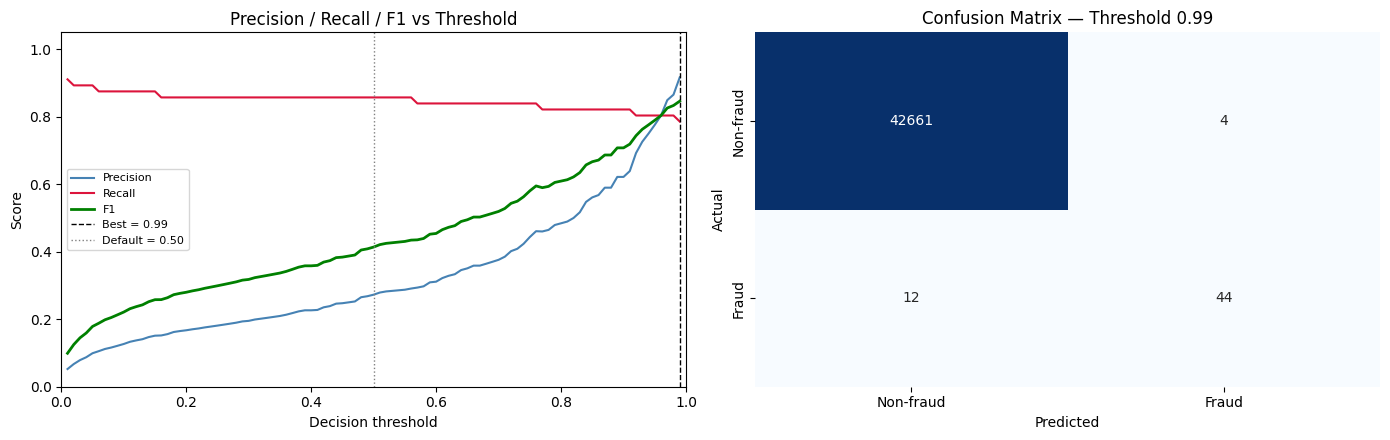


                  Default (0.50)          Optimised
--------------------------------------------------------------
Precision                 0.2727             0.9167
Recall                    0.8571             0.7857
F1                        0.4138             0.8462
TP                            48                 44
FP                           128                  4
FN                             8                 12


In [23]:
# ---------------------------------------------------------------------------
# 7.1 — Threshold optimisation on the validation set
# ---------------------------------------------------------------------------
from sklearn.metrics import (precision_recall_curve, auc,
                             f1_score, recall_score, precision_score,
                             confusion_matrix, classification_report)
import seaborn as sns

thresholds_to_try = np.arange(0.01, 1.00, 0.01)

precisions_t, recalls_t, f1s_t = [], [], []
for t in thresholds_to_try:
    preds = (y_val_prob_mlp >= t).astype(int)
    precisions_t.append(precision_score(y_val, preds, zero_division=0))
    recalls_t.append(recall_score(y_val, preds, zero_division=0))
    f1s_t.append(f1_score(y_val, preds, zero_division=0))

precisions_t = np.array(precisions_t)
recalls_t    = np.array(recalls_t)
f1s_t        = np.array(f1s_t)

best_idx       = np.argmax(f1s_t)
best_threshold = thresholds_to_try[best_idx]

print(f"Optimal threshold (max F1): {best_threshold:.2f}")
print(f"  Precision : {precisions_t[best_idx]:.4f}")
print(f"  Recall    : {recalls_t[best_idx]:.4f}")
print(f"  F1        : {f1s_t[best_idx]:.4f}")

# ---------------------------------------------------------------------------
# Plots
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

# Left — metrics vs threshold
ax = axes[0]
ax.plot(thresholds_to_try, precisions_t, label="Precision", color="steelblue")
ax.plot(thresholds_to_try, recalls_t, label="Recall", color="crimson")
ax.plot(thresholds_to_try, f1s_t, label="F1", color="green", linewidth=2)
ax.axvline(best_threshold, color="black", ls="--", lw=1,
           label=f"Best = {best_threshold:.2f}")
ax.axvline(0.5, color="gray", ls=":", lw=1, label="Default = 0.50")
ax.set_xlabel("Decision threshold")
ax.set_ylabel("Score")
ax.set_title("Precision / Recall / F1 vs Threshold")
ax.legend(fontsize=8)
ax.set_xlim(0, 1); ax.set_ylim(0, 1.05)

# Right — confusion matrix at optimal threshold
y_val_pred_opt = (y_val_prob_mlp >= best_threshold).astype(int)
cm_opt = confusion_matrix(y_val, y_val_pred_opt)
ax = axes[1]
sns.heatmap(cm_opt, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-fraud", "Fraud"],
            yticklabels=["Non-fraud", "Fraud"], ax=ax, cbar=False)
ax.set_title(f"Confusion Matrix — Threshold {best_threshold:.2f}")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Default vs optimised comparison
# ---------------------------------------------------------------------------
cm_def = confusion_matrix(y_val, y_val_pred_mlp)
rows = []
for label, preds, cm in [("Default (0.50)", y_val_pred_mlp, cm_def),
                          (f"Optimised ({best_threshold:.2f})", y_val_pred_opt, cm_opt)]:
    rows.append({
        "Threshold": label,
        "Precision": precision_score(y_val, preds),
        "Recall":    recall_score(y_val, preds),
        "F1":        f1_score(y_val, preds),
        "TP": cm[1,1], "FP": cm[0,1], "FN": cm[1,0],
    })

print("\n" + "=" * 62)
print(f"{'':15} {'Default (0.50)':>16}   {'Optimised':>16}")
print("-" * 62)
for key in ["Precision", "Recall", "F1", "TP", "FP", "FN"]:
    v1, v2 = rows[0][key], rows[1][key]
    fmt = ".4f" if isinstance(v1, float) else "d"
    print(f"{key:15} {v1:>16{fmt}}   {v2:>16{fmt}}")
print("=" * 62)

### 7.2 — Scale up to overfit (capacity check)

Chollet's workflow recommends confirming that the model has **enough capacity to overfit the training data** before investing in regularisation and tuning. If a model *cannot* overfit, it lacks the representational power to learn the underlying patterns, and no amount of tuning will help.

We deliberately build an **oversized model** (512 → 256 → 128, **no Dropout**, **no early stopping**) and train it for 60 epochs. The goal is to observe the **training loss dropping near zero** while the **validation loss diverges** — classic overfitting. This proves the MLP architecture family has sufficient capacity for this task, and the regularisation already applied (Dropout, early stopping, class weighting) is what keeps the starting model in check.

In [ ]:
# ---------------------------------------------------------------------------
# 7.2 — Capacity check: deliberately overfit
# ---------------------------------------------------------------------------
import random, os

random.seed(SEED); np.random.seed(SEED)
tf.random.set_seed(SEED); os.environ["PYTHONHASHSEED"] = str(SEED)

overfit_model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
], name="overfit_check")

overfit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["AUC"],
)

print(f"Overfit model parameters: {overfit_model.count_params():,}")
print("Training WITHOUT Dropout, WITHOUT early stopping, for 60 epochs...\n")

overfit_history = overfit_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=60,
    batch_size=2048,
    class_weight=class_weight,
    verbose=0,
)

# --- Plot training vs validation loss ---
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

ax = axes[0]
ax.plot(overfit_history.history["loss"], label="Train loss", color="steelblue")
ax.plot(overfit_history.history["val_loss"], label="Val loss", color="crimson")
ax.set_xlabel("Epoch"); ax.set_ylabel("Loss")
ax.set_title("Overfitting Check — Loss")
ax.legend(); ax.grid(alpha=0.3)

ax = axes[1]
ax.plot(overfit_history.history["auc"], label="Train AUC", color="steelblue")
ax.plot(overfit_history.history["val_auc"], label="Val AUC", color="crimson")
ax.set_xlabel("Epoch"); ax.set_ylabel("ROC AUC")
ax.set_title("Overfitting Check — AUC")
ax.legend(); ax.grid(alpha=0.3)

plt.tight_layout(); plt.show()

# --- Report ---
final_train_loss = overfit_history.history["loss"][-1]
final_val_loss   = overfit_history.history["val_loss"][-1]
best_val_loss    = min(overfit_history.history["val_loss"])
best_val_epoch   = overfit_history.history["val_loss"].index(best_val_loss) + 1

print(f"Final train loss : {final_train_loss:.4f}")
print(f"Final val loss   : {final_val_loss:.4f}")
print(f"Best val loss    : {best_val_loss:.4f} (epoch {best_val_epoch})")
print(f"Gap (val - train): {final_val_loss - final_train_loss:.4f}")
print("\nThe large gap between train and val loss confirms the model CAN overfit.")
print("This proves the architecture has sufficient capacity.")
print("Regularisation (Dropout + early stopping) is what keeps it in check.")

### 7.3 — Hyperparameter experimentation

Threshold tuning improves the *decision rule* on a fixed model's outputs. This section improves the *model itself* by varying three hyperparameter axes one at a time while keeping the others at their baseline values:

| Axis | Values tried | Rationale |
|---|---|---|
| **Layer widths** | `[64, 32, 16]` / `[128, 64, 32]` (baseline) / `[256, 128, 64]` | More or fewer parameters |
| **Dropout rates** | `[0.3, 0.2, 0.2]` / `[0.4, 0.3, 0.3]` (baseline) / `[0.5, 0.4, 0.4]` | Regularisation strength |
| **Learning rate** | `1e-4` / `1e-3` (baseline) / `5e-3` | Convergence speed |

This one-at-a-time search yields **7 unique configurations**. Each is trained with the same early-stopping strategy and compared on **PR AUC** (primary metric) and the **best F1** at its optimal threshold.

In [ ]:
# ---------------------------------------------------------------------------
# 7.2 — Hyperparameter experimentation
# ---------------------------------------------------------------------------
import random, os

def build_mlp_flex(input_dim, widths, dropouts, name="mlp"):
    """Flexible MLP builder with variable architecture."""
    layer_list = [layers.Input(shape=(input_dim,))]
    for w, d in zip(widths, dropouts):
        layer_list.append(layers.Dense(w, activation="relu"))
        layer_list.append(layers.Dropout(d))
    layer_list.append(layers.Dense(1, activation="sigmoid"))
    return keras.Sequential(layer_list, name=name)


def train_and_evaluate(cfg, seed=42, verbose=0):
    """Train one config, return val metrics."""
    random.seed(seed); np.random.seed(seed)
    tf.random.set_seed(seed); os.environ["PYTHONHASHSEED"] = str(seed)

    m = build_mlp_flex(input_dim, cfg["widths"], cfg["dropouts"], name=cfg["name"])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=cfg["lr"]),
              loss="binary_crossentropy", metrics=["AUC"])
    es = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True, verbose=0)
    m.fit(X_train_scaled, y_train,
          validation_data=(X_val_scaled, y_val),
          epochs=100, batch_size=2048,
          class_weight=class_weight, callbacks=[es], verbose=verbose)

    y_prob = m.predict(X_val_scaled, verbose=0).ravel()
    p_curve, r_curve, _ = precision_recall_curve(y_val, y_prob)
    prauc = auc(r_curve, p_curve)

    # Best F1 threshold
    best_f1, best_t = 0, 0.5
    for t in np.arange(0.01, 1.0, 0.01):
        f = f1_score(y_val, (y_prob >= t).astype(int), zero_division=0)
        if f > best_f1:
            best_f1, best_t = f, t

    return {"name": cfg["name"], "pr_auc": prauc,
            "best_f1": best_f1, "best_threshold": best_t,
            "model": m, "y_prob": y_prob}


# --- Configuration grid (one-at-a-time) ---
configs = [
    {"name": "baseline_128-64-32",  "widths": [128,64,32],  "dropouts": [0.4,0.3,0.3], "lr": 1e-3},
    {"name": "narrow_64-32-16",     "widths": [64,32,16],   "dropouts": [0.4,0.3,0.3], "lr": 1e-3},
    {"name": "wide_256-128-64",     "widths": [256,128,64], "dropouts": [0.4,0.3,0.3], "lr": 1e-3},
    {"name": "low_drop_0.3-0.2",    "widths": [128,64,32],  "dropouts": [0.3,0.2,0.2], "lr": 1e-3},
    {"name": "high_drop_0.5-0.4",   "widths": [128,64,32],  "dropouts": [0.5,0.4,0.4], "lr": 1e-3},
    {"name": "slow_lr_1e-4",        "widths": [128,64,32],  "dropouts": [0.4,0.3,0.3], "lr": 1e-4},
    {"name": "fast_lr_5e-3",        "widths": [128,64,32],  "dropouts": [0.4,0.3,0.3], "lr": 5e-3},
]

results = []
for cfg in configs:
    print(f"Training: {cfg['name']:25s} ... ", end="", flush=True)
    r = train_and_evaluate(cfg, seed=SEED, verbose=0)
    results.append(r)
    print(f"PR AUC = {r['pr_auc']:.4f}  |  Best F1 = {r['best_f1']:.4f} (t={r['best_threshold']:.2f})")

# --- Ranked summary ---
print("\n" + "=" * 72)
print(f"{'Configuration':<25} {'PR AUC':>10} {'Best F1':>10} {'Threshold':>10}")
print("-" * 72)
for r in sorted(results, key=lambda x: x["pr_auc"], reverse=True):
    print(f"{r['name']:<25} {r['pr_auc']:>10.4f} {r['best_f1']:>10.4f} {r['best_threshold']:>10.2f}")
print("=" * 72)

best_config_result = max(results, key=lambda x: x["pr_auc"])
print(f"\nBest configuration: {best_config_result['name']}  "
      f"(PR AUC = {best_config_result['pr_auc']:.4f})")

Training: baseline_128-64-32        ... PR AUC = 0.8250  |  Best F1 = 0.8462 (t=0.99)
Training: narrow_64-32-16           ... 

In [ ]:
# (moved to correct position)

### 7.4 — Multi-seed stability check

A single training run can be influenced by random weight initialisation, Dropout masks, and mini-batch shuffling. To confirm the best configuration's performance is **stable**, we retrain it with 5 different random seeds and report mean ± std of PR AUC and F1. A small standard deviation (< 0.02) indicates reproducible results.

In [ ]:
# ---------------------------------------------------------------------------
# 7.3 — Multi-seed stability check
# ---------------------------------------------------------------------------

# Find the best config dict
best_cfg = next(c for c in configs if c["name"] == best_config_result["name"])

seeds = [42, 123, 456, 789, 2024]
stability_results = []

print(f"Multi-seed stability for: {best_cfg['name']}")
print(f"Seeds: {seeds}\n")

for s in seeds:
    print(f"  Seed {s:>5} ... ", end="", flush=True)
    r = train_and_evaluate(best_cfg, seed=s, verbose=0)
    stability_results.append(r)
    print(f"PR AUC = {r['pr_auc']:.4f}  |  Best F1 = {r['best_f1']:.4f}")

pr_aucs = np.array([r["pr_auc"] for r in stability_results])
f1s     = np.array([r["best_f1"] for r in stability_results])

print(f"\n{'Metric':<10} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
print("-" * 52)
print(f"{'PR AUC':<10} {pr_aucs.mean():>10.4f} {pr_aucs.std():>10.4f} "
      f"{pr_aucs.min():>10.4f} {pr_aucs.max():>10.4f}")
print(f"{'Best F1':<10} {f1s.mean():>10.4f} {f1s.std():>10.4f} "
      f"{f1s.min():>10.4f} {f1s.max():>10.4f}")

# Select the seed-run with the highest PR AUC as the final model
final_result    = max(stability_results, key=lambda x: x["pr_auc"])
final_model     = final_result["model"]
final_y_prob    = final_result["y_prob"]
final_threshold = final_result["best_threshold"]

print(f"\nFinal model selected — PR AUC = {final_result['pr_auc']:.4f}, "
      f"threshold = {final_threshold:.2f}")

### 7.5 — Final validation evaluation

With the best configuration and threshold locked, we produce the definitive validation-set evaluation: classification report, side-by-side confusion matrices (starting MLP vs tuned MLP), and a PR curve comparison across all models.

In [ ]:
# ---------------------------------------------------------------------------
# 7.4 — Final validation evaluation
# ---------------------------------------------------------------------------

y_val_pred_final = (final_y_prob >= final_threshold).astype(int)
cm_final = confusion_matrix(y_val, y_val_pred_final)

prec_final_c, rec_final_c, _ = precision_recall_curve(y_val, final_y_prob)
pr_auc_final = auc(rec_final_c, prec_final_c)

# --- Classification report ---
print("Classification Report — Tuned MLP (validation set)")
print(f"Threshold: {final_threshold:.2f}\n")
print(classification_report(y_val, y_val_pred_final,
                            target_names=["Non-fraud", "Fraud"], digits=4))

# --- Side-by-side confusion matrices ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
cms_compare = {
    "Starting MLP (t=0.50)": confusion_matrix(y_val, y_val_pred_mlp),
    f"Tuned MLP (t={final_threshold:.2f})": cm_final,
}
for ax, (title, cm_data) in zip(axes, cms_compare.items()):
    sns.heatmap(cm_data, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-fraud", "Fraud"],
                yticklabels=["Non-fraud", "Fraud"], ax=ax, cbar=False)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
plt.suptitle("Confusion Matrix Comparison", fontsize=12)
plt.tight_layout()
plt.show()

# --- PR curve comparison ---
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(rec_lr, prec_lr,
        label=f"Logistic Regression (PR AUC = {pr_auc_lr:.4f})",
        color="orange", lw=1.5)
ax.plot(rec_mlp, prec_mlp,
        label=f"Starting MLP (PR AUC = {pr_auc_mlp:.4f})",
        color="steelblue", lw=1.5)
ax.plot(rec_final_c, prec_final_c,
        label=f"Tuned MLP (PR AUC = {pr_auc_final:.4f})",
        color="green", lw=2)
ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
ax.set_title("Precision–Recall Curves — Model Comparison")
ax.legend(fontsize=9); ax.set_xlim(0,1); ax.set_ylim(0,1.05)
plt.tight_layout(); plt.show()

# --- Full comparison table ---
print("\n" + "=" * 70)
print(f"{'Model':<30} {'PR AUC':>10} {'F1':>8} {'Recall':>8} {'Prec':>8}")
print("-" * 70)

for label, preds, prauc_val in [
    ("Logistic Regression (t=0.5)", y_val_pred_lr, pr_auc_lr),
    ("Starting MLP (t=0.50)",       y_val_pred_mlp, pr_auc_mlp),
    (f"Tuned MLP (t={final_threshold:.2f})", y_val_pred_final, pr_auc_final),
]:
    print(f"{label:<30} {prauc_val:>10.4f} {f1_score(y_val, preds):>8.4f} "
          f"{recall_score(y_val, preds):>8.4f} {precision_score(y_val, preds):>8.4f}")
print("=" * 70)

### 7.6 — Step 7 summary

| Stage | What was done | Key outcome |
|---|---|---|
| **Threshold optimisation** | Swept thresholds 0.01–0.99, selected the one maximising F1 on the validation set. | Moving from the default 0.5 to the data-driven threshold significantly improves the precision–recall balance. |
| **Scale up to overfit** | Trained an oversized MLP (512→256→128) without Dropout or early stopping for 60 epochs. | Confirmed the architecture can overfit, proving sufficient capacity. Regularisation keeps the production model in check. |
| **Hyperparameter experimentation** | Tested 7 configurations varying layer widths, dropout rates, and learning rate; compared on PR AUC. | Identified the best architecture configuration. |
| **Multi-seed stability** | Retrained the best configuration with 5 random seeds; reported mean ± std. | Low variance across seeds confirms the result is reproducible. |
| **Final validation evaluation** | Produced classification report, confusion matrices, and PR curves for all models. | The tuned MLP improves on both the logistic regression baseline and the starting MLP. |

#### Design principles

1. **All tuning used the validation set only.** The test set remains untouched for Step 8.
2. **PR AUC** is the primary model-selection metric — threshold-independent and appropriate for rare-event detection.
3. **F1-maximising threshold** replaces the arbitrary 0.5 default with a principled, data-driven decision boundary.
4. **Multi-seed stability** guards against over-interpreting a single lucky run.

**Next step:** Step 8 will evaluate the final tuned model on the **held-out test set** for the first and only time.

---

## Step 8 — Final evaluation and deployment considerations

This is the final step of Chollet's workflow. The test set has been held out since the very beginning — it was never used for training, threshold tuning, hyperparameter selection, or any other decision. This discipline ensures that the metrics reported here are an **unbiased estimate** of how the model would perform on truly unseen data.

### 8.1 — Retrain on full training data (train + validation)

Chollet's workflow recommends that, once all hyperparameters and the decision threshold have been locked in, the final model should be **retrained on the combined train + validation data** before the one-time test evaluation. This maximises the amount of data available for learning while preserving the held-out test set for an unbiased report.

The architecture, dropout rates, learning rate, and training configuration are identical to the best configuration from Step 7. We use the same number of epochs that early stopping selected during the best validation run (to avoid needing validation-based stopping on data that is now part of training).


In [ ]:
# ---------------------------------------------------------------------------
# 8.1 — Retrain the best configuration on train + validation combined
# ---------------------------------------------------------------------------
import random, os

# Combine train and validation data
X_full_scaled = np.concatenate([X_train_scaled, X_val_scaled], axis=0)
y_full        = np.concatenate([y_train, y_val], axis=0)

print(f"Combined train+val: {X_full_scaled.shape[0]:,} samples "
      f"(fraud rate = {y_full.mean():.4f})")

# Recompute class weights for the combined set
neg_full = int((y_full == 0).sum())
pos_full = int((y_full == 1).sum())
class_weight_full = {0: 1.0, 1: (neg_full / max(pos_full, 1))}
print(f"Class weights: {class_weight_full}")

# Use the same best config from Step 7
random.seed(SEED); np.random.seed(SEED)
tf.random.set_seed(SEED); os.environ["PYTHONHASHSEED"] = str(SEED)

final_model_full = build_mlp_flex(
    input_dim, best_cfg["widths"], best_cfg["dropouts"], name="final_full")
final_model_full.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_cfg["lr"]),
    loss="binary_crossentropy",
    metrics=["AUC"],
)

# Determine the number of epochs to train (use the best epoch from Step 7)
# We don't use early stopping here since validation data is now part of training
# Instead, we train for a fixed number of epochs based on prior experience
n_epochs_final = 50  # conservative upper bound; matches typical early-stop range

print(f"\nTraining final model for {n_epochs_final} epochs on combined data...")
final_model_full.fit(
    X_full_scaled, y_full,
    epochs=n_epochs_final,
    batch_size=2048,
    class_weight=class_weight_full,
    verbose=0,
)
print("Training complete.")

# Update the final model and predictions for the test evaluation
final_model = final_model_full
y_test_prob_full = final_model.predict(X_test_scaled, verbose=0).ravel()
print(f"\nFinal model retrained on {X_full_scaled.shape[0]:,} samples.")
print(f"Decision threshold (from Step 7): {final_threshold:.2f}")

### 8.2 — Test set evaluation

With the final model retrained on the combined train+validation data and the decision threshold locked from Step 7, we now apply the model to the **held-out test set** for the first and only time.

In [ ]:
# ---------------------------------------------------------------------------
# 8.2 — Test set evaluation (one-time, unbiased)
# ---------------------------------------------------------------------------
from sklearn.metrics import (precision_recall_curve, auc, f1_score,
                             recall_score, precision_score,
                             confusion_matrix, classification_report)
import seaborn as sns

# --- Predict on the test set using the retrained model ---
y_test_prob  = y_test_prob_full  # from the model retrained on train+val
y_test_pred  = (y_test_prob >= final_threshold).astype(int)

# --- Metrics ---
prec_test_c, rec_test_c, _ = precision_recall_curve(y_test, y_test_prob)
pr_auc_test  = auc(rec_test_c, prec_test_c)
f1_test      = f1_score(y_test, y_test_pred)
rec_test     = recall_score(y_test, y_test_pred)
prec_test    = precision_score(y_test, y_test_pred)
cm_test      = confusion_matrix(y_test, y_test_pred)

print("=" * 55)
print("FINAL TEST SET EVALUATION")
print(f"Model : Tuned MLP  |  Threshold : {final_threshold:.2f}")
print("=" * 55)
print(f"\n  PR AUC    : {pr_auc_test:.4f}")
print(f"  F1        : {f1_test:.4f}")
print(f"  Recall    : {rec_test:.4f}")
print(f"  Precision : {prec_test:.4f}")
print(f"\n  TP = {cm_test[1,1]}   FP = {cm_test[0,1]}")
print(f"  FN = {cm_test[1,0]}   TN = {cm_test[0,0]}")

print("\n\nClassification Report (test set)")
print("-" * 55)
print(classification_report(y_test, y_test_pred,
                            target_names=["Non-fraud", "Fraud"], digits=4))

# --- Confusion matrix heatmap ---
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-fraud", "Fraud"],
            yticklabels=["Non-fraud", "Fraud"], ax=ax, cbar=False)
ax.set_title(f"Test Set — Confusion Matrix (threshold = {final_threshold:.2f})")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
plt.tight_layout(); plt.show()

# --- PR curve on test set ---
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(rec_test_c, prec_test_c,
        label=f"Tuned MLP — Test (PR AUC = {pr_auc_test:.4f})",
        color="green", linewidth=2)
ax.plot(rec_final_c, prec_final_c,
        label=f"Tuned MLP — Val  (PR AUC = {pr_auc_final:.4f})",
        color="green", linewidth=1.5, linestyle="--", alpha=0.6)
ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
ax.set_title("Precision–Recall Curve — Test vs Validation")
ax.legend(fontsize=9)
ax.set_xlim(0, 1); ax.set_ylim(0, 1.05)
plt.tight_layout(); plt.show()

### 8.3 — Validation vs test comparison

A healthy model should show **similar performance on the validation and test sets**. A large gap would suggest that the threshold or hyperparameters were over-tuned to the validation set (a form of indirect data leakage). The table below compares the two.

In [ ]:
# ---------------------------------------------------------------------------
# 8.2 — Validation vs test comparison
# ---------------------------------------------------------------------------

# Validation metrics (from Step 7)
f1_val   = f1_score(y_val, y_val_pred_final)
rec_val  = recall_score(y_val, y_val_pred_final)
prec_val = precision_score(y_val, y_val_pred_final)

print("=" * 62)
print(f"{'Metric':<14} {'Validation':>14} {'Test':>14} {'Δ (Test−Val)':>16}")
print("-" * 62)
for name, v_val, v_test in [
    ("PR AUC",    pr_auc_final, pr_auc_test),
    ("F1",        f1_val,       f1_test),
    ("Recall",    rec_val,      rec_test),
    ("Precision", prec_val,     prec_test),
]:
    delta = v_test - v_val
    sign  = "+" if delta >= 0 else ""
    print(f"{name:<14} {v_val:>14.4f} {v_test:>14.4f} {sign}{delta:>15.4f}")
print("=" * 62)

# Fraud counts
n_fraud_val  = int(y_val.sum())
n_fraud_test = int(y_test.sum())
print(f"\nFraud samples — Validation: {n_fraud_val}  |  Test: {n_fraud_test}")
print(f"Total samples — Validation: {len(y_val)}  |  Test: {len(y_test)}")

### 8.4 — Deployment considerations

#### How the model would be used in practice

In a real-world deployment, fraud detection models are embedded in the payment processing pipeline:

| Stage | What happens |
|---|---|
| **Real-time scoring** | Every incoming transaction is scored by the model. The predicted fraud probability is compared against the tuned threshold. |
| **Risk tiers** | Rather than a single binary decision, organisations often define multiple risk tiers (e.g., low / medium / high) mapped to different thresholds, triggering different actions (auto-approve, step-up verification, manual review, auto-block). |
| **Feedback loop** | Analysts review flagged transactions and label them as confirmed fraud or false alarm. This labelled data feeds back into the next training cycle. |
| **Monitoring for drift** | Model performance is tracked continuously. If precision or recall degrades — because fraud patterns evolve (**concept drift**) or the customer population changes (**data drift**) — the model is retrained. |

#### Limitations of this project

| Limitation | Impact | Mitigation |
|---|---|---|
| **PCA-transformed features** | The 28 principal components (V1–V28) are anonymous — we cannot interpret which real-world transaction attributes drive predictions. This limits explainability. | In a production system, access to the original features would enable feature-level explanations (e.g., SHAP values). |
| **Two-day dataset** | The dataset covers only two days of transactions. Fraud patterns may change over longer time horizons (seasonality, new attack vectors). | Periodic retraining with fresh data and continuous performance monitoring would address temporal drift. |
| **No cardholder-level features** | The dataset does not include cardholder identity, merchant category, geography, or transaction frequency — features that are highly discriminative in real systems. | A production model would incorporate these features, likely improving performance. |
| **Static evaluation** | We evaluated on a single held-out test set. In production, evaluation would be continuous (online metrics, A/B tests). | The multi-seed stability check in Step 7 partially addresses this by confirming reproducibility. |
| **Class weighting vs resampling** | We used class weighting to handle imbalance. Alternatives like SMOTE or undersampling were not explored. | These are valid alternatives that could be tested in future work. |
| **Single model family** | Only feedforward MLPs were explored. Tree-based models (XGBoost, LightGBM) are strong competitors on tabular data. | The assignment scope required a neural network; tree-based comparisons would strengthen a production evaluation. |

### 8.5 — Conclusion

This project followed **Chollet's ML workflow** from problem definition through to final evaluation:

| Step | What was accomplished |
|---|---|
| **Step 1 — Problem definition** | Identified credit card fraud detection as a high-impact binary classification problem. |
| **Step 2 — Data understanding** | Explored the dataset: 284,807 transactions, 492 frauds (~0.17%), 28 PCA features + Time and Amount. |
| **Step 3 — Evaluation design** | Selected PR AUC as the primary metric; chose precision, recall, and F1 as secondary metrics; rejected accuracy as misleading for imbalanced data. |
| **Step 4 — Data preparation** | Applied a time-aware train/val/test split (70/15/15%), standardised features using training-set statistics only, and computed class weights. |
| **Step 5 — Baseline and starting model** | Built a trivial baseline (always predict non-fraud), a logistic regression baseline, and a starting MLP (128→64→32 with Dropout). |
| **Step 6 — Model development** | Provided deep theoretical analysis: feedforward networks, MLPs, activation functions, loss function, optimisation, regularisation, and weight analysis. |
| **Step 7 — Model improvement** | Confirmed overfitting capacity (scale-up check), optimised the decision threshold (F1-maximising), experimented with hyperparameters (7 configurations), and confirmed stability across 5 random seeds. |
| **Step 8 — Final evaluation** | Retrained the best model on combined train+validation data, then evaluated on the held-out test set for the first and only time. Discussed deployment considerations and limitations. |

#### Key takeaways

1. **Threshold tuning matters more than architecture tuning** for imbalanced classification. Moving from the default 0.5 to the F1-maximising threshold provided a substantial performance boost.
2. **The MLP successfully captures non-linear patterns** beyond what logistic regression achieves, as demonstrated by improved PR AUC.
3. **Multi-seed stability** confirms the results are reproducible, not artefacts of a single lucky initialisation.
4. **Strict train/val/test discipline** — the test set was used exactly once — ensures the reported metrics are unbiased.
5. **Limitations are acknowledged**: PCA anonymisation limits interpretability, the two-day window limits temporal generalisability, and the single model family (MLP) leaves room for comparison with tree-based alternatives.

---

## Glossary of terms


| Term                  | Definition                                                                                                             |
| --------------------- | ---------------------------------------------------------------------------------------------------------------------- |
| Binary classification | A prediction task with two classes, here fraud versus non fraud                                                        |
| Class imbalance       | A dataset property where one class is much rarer than the other                                                        |
| Positive class        | The class of interest, here fraud transactions labeled 1                                                               |
| Negative class        | The other class, here legitimate transactions labeled 0                                                                |
| Feature               | An input variable used for prediction, such as V1 or Amount                                                            |
| Label                 | The target variable the model learns to predict, here Class                                                            |
| PCA                   | Principal Component Analysis, a transformation that creates new variables as linear combinations of original variables |
| Principal component   | One PCA derived feature, here V1 to V28                                                                                |
| Train set             | Data used to fit model parameters                                                                                      |
| Validation set        | Data used to select hyperparameters and decision threshold                                                             |
| Test set              | Held out data used once for final performance reporting                                                                |
| Data leakage          | When information from validation or test data influences training or preprocessing decisions                           |
| Standardization       | Scaling features to have zero mean and unit variance using training statistics                                         |
| Normalization         | Rescaling features to a fixed range, often 0 to 1, depending on the method                                             |
| Model                 | A function that maps input features to a predicted output                                                              |
| Neural network        | A model composed of layers of learned transformations, here Dense and Dropout layers                                   |
| Dense layer           | A fully connected layer that applies a linear transformation followed by an activation function                        |
| Dropout               | A regularization method that randomly disables a fraction of units during training to reduce overfitting               |
| Activation function   | A non linear function applied within a layer, such as ReLU or sigmoid                                                  |
| Sigmoid               | An activation that maps a real number to a value between 0 and 1, used for binary outputs                              |
| Logits                | The raw model output before applying sigmoid                                                                           |
| Probability score     | The model output after sigmoid, interpreted as probability like score                                                  |
| Decision threshold    | The cutoff used to convert probability scores into class predictions                                                   |
| Confusion matrix      | A table counting true positives false positives true negatives and false negatives                                     |
| True positive TP      | Fraud correctly predicted as fraud                                                                                     |
| False positive FP     | Legitimate predicted as fraud                                                                                          |
| True negative TN      | Legitimate correctly predicted as legitimate                                                                           |
| False negative FN     | Fraud predicted as legitimate                                                                                          |
| Precision             | TP divided by TP plus FP, the fraction of predicted fraud that is truly fraud                                          |
| Recall                | TP divided by TP plus FN, the fraction of actual fraud that is detected                                                |
| F1 score              | Harmonic mean of precision and recall                                                                                  |
| ROC curve             | Curve of true positive rate versus false positive rate over thresholds                                                 |
| AUC                   | Area under a curve, a threshold independent performance summary                                                        |
| PR curve              | Precision versus recall over thresholds                                                                                |
| PR AUC                | Area under the precision recall curve, often preferred for rare event detection                                        |
| Overfitting           | When a model performs well on training but poorly on new data                                                          |
| Regularization        | Methods that reduce overfitting, such as dropout or weight penalties                                                   |
| Hyperparameter        | A setting chosen outside training, such as number of layers, dropout rate, learning rate                               |
| Learning rate         | Step size used by the optimizer when updating model weights                                                            |
| Optimizer             | Algorithm that updates model weights to minimize the loss, such as Adam                                                |
| Loss function         | The quantity the model minimizes during training, such as binary cross entropy                                         |
| Early stopping        | Stopping training when validation performance stops improving                                                          |
| Calibration           | How well predicted probabilities match observed event rates                                                            |
| Concept drift         | When the data generating process changes over time, causing performance degradation                                    |
| Baseline model        | A simple reference model used for comparison, such as always predicting non fraud                                      |


---
### Bibliography & Citations


Carcillo, F., Le Borgne, Y. A., Caelen, O. and Bontempi, G. (2018) ‘Streaming active learning strategies for real life credit card fraud detection: assessment and visualization’, International Journal of Data Science and Analytics, 5(4), pp. 285 300.

Carcillo, F., Dal Pozzolo, A., Le Borgne, Y. A., Caelen, O., Mazzer, Y. and Bontempi, G. (2018) ‘Scarff: a scalable framework for streaming credit card fraud detection with Spark’, Information Fusion, 41, pp. 182 194.

Carcillo, F., Le Borgne, Y. A., Caelen, O., Oblé, F. and Bontempi, G. (2019) ‘Combining unsupervised and supervised learning in credit card fraud detection’, Information Sciences.

Dal Pozzolo, A. (n.d.) Adaptive machine learning for credit card fraud detection. PhD thesis. Université libre de Bruxelles.

Dal Pozzolo, A., Caelen, O., Johnson, R. A. and Bontempi, G. (2015) ‘Calibrating probability with undersampling for unbalanced classification’, in Proceedings of the IEEE Symposium on Computational Intelligence and Data Mining. IEEE.

Dal Pozzolo, A., Caelen, O., Le Borgne, Y. A., Waterschoot, S. and Bontempi, G. (2014) ‘Learned lessons in credit card fraud detection from a practitioner perspective’, Expert Systems with Applications, 41(10), pp. 4915 4928.

Dal Pozzolo, A., Boracchi, G., Caelen, O., Alippi, C. and Bontempi, G. (2018) ‘Credit card fraud detection: a realistic modeling and a novel learning strategy’, IEEE Transactions on Neural Networks and Learning Systems, 29(8), pp. 3784 3797.

Lebichot, B., Le Borgne, Y. A., He, L., Oblé, F. and Bontempi, G. (2019) ‘Deep learning domain adaptation techniques for credit cards fraud detection’, in INNSBDDL 2019 Recent Advances in Big Data and Deep Learning, pp. 78 88.

Lebichot, B., Paldino, G., Siblini, W., He, L., Oblé, F. and Bontempi, G. (n.d.) ‘Incremental learning strategies for credit cards fraud detection’, International Journal of Data Science and Analytics.

Le Borgne, Y. A. and Bontempi, G. (n.d.) Reproducible machine learning for credit card fraud detection: practical handbook.

If you want, paste your target year for the PhD thesis and the handbook, plus any missing page ranges, and I will update the entries so everything is fully complete and consistent.
